# MATH70076 Data Science

## 2024/25 - Assessment 2

Completed by 01909412, Imperial College London

For interactive elements to work, please run all cells sequentially once.

---

## <center>TRACING THE MAGA ELECTORATE - A REPLICATION & EXPANSIVE STUDY OF US ELECTIONS</center>

### Abstract

The dramatic intensification of cultural and political fault lines in the United States has rendered anecdotal accounts of voter behavior insufficient for rigorous analysis. Leveraging nationally representative public-use data from AP VoteCast (approximately 133 000 respondents in 2020 and 140 000 in 2024), this notebook constructs a fully reproducible pipeline to dissect the evolution and composition of the "MAGA" electorate. We begin by cleaning and harmonizing over 700 raw variables and applying post-stratification weights to generate a trustworthy portrait of Trump supporters at two pivotal election cycles. Next, we employ Sankey diagrams to trace individual voting trajectories from 2016 through 2024, illuminating patterns of loyalty and defection. We then turn to unsupervised manifold learning - UMAP followed by HDBSCAN - to uncover latent clusters in both universal demographic features and thematic survey modules, revealing sharply delineated pro- and non-MAGA blocs. Finally, we subject an array of culturally resonant markers to logistic regression, and synthesize the most influential predictors in a volcano plot of log odds versus significance.

> All data processing steps, modeling code, and interactive visualizations are openly available to ensure full reproducibility and to foster further inquiry into the polarized realignment of American voters.

### Introduction

The 2020 and 2024 U.S. presidential contests have been fought amid a maelstrom of hyper-partisan rhetoric, viral social-media narratives, and unprecedented legal and institutional upheavals. In this charged atmosphere, competing news cycles amplify every rumor, prejudice and scandal, often drowning out the underlying currents of voter sentiment. Yet, as the world's foremost economic and military power, the United States' internal realignments carry profound consequences for global markets, security alliances, transnational governance and academic interest. Distinguishing enduring shifts in the electorate from the cacophony of momentary headlines is therefore crucial: not only for political strategists and social scientists, but for anyone seeking to anticipate the broader trajectory of international affairs.

To navigate this complexity, we draw on the [Associated Press's VoteCast](https://apnorc.org/projects/ap-votecast/) public-use files in both general elections of [2020](https://apnorc.org/projects/ap-votecast-2020-general-elections/) and [2024](https://apnorc.org/projects/ap-votecast-2024-general-election/): probability-calibrated, survey-weighted collections of more than a quarter-million respondents across two election cycles. By harmonizing over hundreds of variables spanning basic demographics, ideological orientation, and thematic sub-form modules, we create a unified dataset capable of addressing two core questions: how was the profile of the Trump-aligned voter in 2020 and 2024, and what latent structures underlie that alignment?

Our approach proceeds in three stages. First, we establish a baseline portrait of the electorate by applying the official post-stratification weights to key demographic and attitudinal measures. Second, we trace individual loyalty and defection through Sankey visualizations, revealing the flow of votes from 2016 into the subsequent two cycles. Third, we probe the deeper architecture of political identity by combining UMAP dimensionality reduction with HDBSCAN clustering - first on the universal variables that every respondent answered, and then within each thematic sub-form - to expose the emergent blocs that align with MAGA support. Finally, we subject a wide range of culturally salient markers, from firearm ownership to [pet companionship](https://www.youtube.com/watch?v=SYRd0s6xBDY) and beyond, to survey-weighted logistic regression, culminating in a volcano plot that highlights the most potent predictors of Trump affinity.

By weaving together transparent cleaning procedures, modern unsupervised learning techniques, and classical inferential models, this project lays a reproducible foundation for disentangling genuine patterns in the MAGA electorate from the surrounding noise. The code and interactive figures that follow are designed not only to replicate our findings, but to empower further exploration of the polarized landscape defining early-2020s American politics.

### Ethics Statement

This analysis relies exclusively on the publicly released 2020 and 2024 AP VoteCast microdata, codebooks, and questionnaire documentation. All primary data have been collected under the rigorous protocols of AP-NORC, including institutional review approval, respondent informed consent, removal of direct identifiers, and cell‐suppression of any responses that could enable re-identification. The supplied survey weights are calibrated to certified state vote totals, ensuring that our in-notebook analyses require no additional external linkage.

We impose three further commitments in our own handling of these data:

**1. No supplementary data linkage.**  
All analyses are conducted within the confines of the cleaned VoteCast files. No external voter‐file data, social-media information, geolocation data, or other identifying sources are appended; only necessary Python library dependencies for data processing are introduced.

**2. Full transparency and reproducibility.**  
Every cleaning script, weight adjustment, visualization routine, and statistical model is provided in this open Python notebook. Readers may regenerate every table, chart, and result directly from the raw CSV files without any hidden steps.

**3. Analytical neutrality.**  
The author declares no personal, financial, or organizational ties to any candidate, party, or ideological movement discussed herein. Descriptors such as "MAGA" and references to topics such as "JANSIXTH" are employed strictly as analytical labels. Reported statistical associations are descriptive and should not be interpreted as normative endorsements.

Finally, we acknowledge that certain biases, such as differential non-response among hard-to-reach populations or sub-form wording effects, originate in the original survey design. Wherever such limitations may influence interpretation (for example, concentrated missingness in specific modules), we flag them explicitly in the Results and Discussion sections.  

---

### First look

Before any recoding or weighting, we perform a preliminary inspection of the raw 2020 and 2024 CSV files. The diagnostic script below then computes row counts to confirm we have the full national release, tabulates column counts to map structural namings, reports file sizes to anticipate memory requirements, and displays the first five records alongside the complete header lists. This quick glance reveals AP-NORC's naming conventions and flags any oddities, informing three immediate choices: treat all fields as text until explicitly parsed, retain every header to preserve skip-logic context, and defer the heavy favourability module in favor of a curated core subset.

In [1]:
import pandas as pd
import os

# Path to file
files = ["AP_VOTECAST_2020_GENERAL_1224.csv",
         "AP_VOTECAST_2024_GENERAL.csv"]

metrics = []
for f in files:
    size_bytes = os.path.getsize(f)
    size_mb = size_bytes / (1024 * 1024)
    
    # Row count (excluding header)
    with open(f, 'r', encoding='utf-8') as file:
        nrows = sum(1 for _ in file) - 1
    
    # Column count
    df_header = pd.read_csv(f, nrows=0)
    ncols = len(df_header.columns)
    
    metrics.append({"filename": f,
                    "rows": nrows,
                    "columns": ncols,
                    "size_mb": round(size_mb, 2)
                   })

# Display as a dataframe
display(pd.DataFrame(metrics))

filename    rows  columns  size_mb
0  AP_VOTECAST_2020_GENERAL_1224.csv  133103      300   282.78
1       AP_VOTECAST_2024_GENERAL.csv  139938      466   366.95

By loading every column as strings, we preserve the original parenthesized response codes and avoid costly `pandas` automatic type inference. 

In [2]:
# Load and preview the first few rows
df20 = pd.read_csv("AP_VOTECAST_2020_GENERAL_1224.csv", dtype=str)
df24 = pd.read_csv("AP_VOTECAST_2024_GENERAL.csv", dtype=str)

print("First 5 rows of 2020 dataset:")
display(df20.head(5))

print("\nFirst 5 rows of 2024 dataset:")
display(df24.head(5))

# Inspect column counts and names
pd.set_option('display.max_columns', None)
print(f"\n2020 dataset has {df20.shape[1]} columns:")
print(df20.columns.tolist())

print(f"\n2024 dataset has {df24.shape[1]} columns:")
print(df24.columns.tolist())
pd.reset_option('display.max_columns')

First 5 rows of 2020 dataset:


SU_ID POLLCLOSE_STATE_WEIGHT FINALVOTE_STATE_WEIGHT  \
0  1000001           615.19723434           0.4932228834   
1  1000002           530.26217093           0.3749180336   
2  1000003           322.87716319           0.1903429041   
3  1000004           574.16661721           0.1199050342   
4  1000005           1101.6705525           0.6596045213   

  POLLCLOSE_NATIONAL_WEIGHT FINALVOTE_NATIONAL_WEIGHT       MODE  \
0              443.79662145              0.3363630848  (1) Phone   
1              396.60725975              0.3983857716    (2) Web   
2              225.77868559              0.2012686057    (2) Web   
3              450.38016669              0.3473415768    (2) Web   
4              740.12826638              0.5861417447    (2) Web   

           P_STATE        STATENUM                       LVA  \
0    (MO) Missouri   (24) Missouri  (1) Extremely interested   
1        (OH) Ohio       (35) Ohio  (1) Extremely interested   
2     (GA) Georgia    (10) Georgia  (1) Extremely interested   
3  (CA) California  (5) California  (1) Extremely interested   
4     (AL) Alabama     (2) Alabama  (1) Extremely interested   

                        LVB  ...                          RELIG4 BORNAGAIN  \
0       (5) I already voted  ...                    (2) Catholic       NaN   
1  (1) Definitely will vote  ...  (1) Protestant/Other Christian   (1) Yes   
2  (1) Definitely will vote  ...  (1) Protestant/Other Christian       NaN   
3       (5) I already voted  ...                       (3) Other       NaN   
4  (1) Definitely will vote  ...  (1) Protestant/Other Christian       NaN   

  BORNAGAINSTATE               ATTENDANCE      MARRIED     MARRIED2    LGBT  \
0            NaN                      NaN          NaN          NaN     NaN   
1        (1) Yes  (5) Once a week or more  (2) Married  (1) Married  (2) No   
2            NaN                      NaN          NaN          NaN     NaN   
3            NaN                      NaN          NaN          NaN     NaN   
4            NaN                      NaN          NaN          NaN     NaN   

        SIZEPLACE        RESIDENCY    FORMFLAG  
0  (3) Small town              NaN  (2) Form 2  
1    (2) Suburban              NaN  (1) Form 1  
2       (1) Urban  (4) 11-20 years  (2) Form 2  
3       (1) Urban              NaN  (4) Form 4  
4  (3) Small town              NaN  (2) Form 2  

[5 rows x 300 columns]


First 5 rows of 2024 dataset:


SU_ID POLLCLOSE_STATE_WEIGHT FINALVOTE_STATE_WEIGHT  \
0  1000001           546.79813629           0.3573655622   
1  1000002           139.87402432           0.2315624001   
2  1000003           1434.0818469           1.5080094782   
3  1000004           634.07127481           0.3805041358   
4  1000005           1.2414513944           0.0019974639   

  POLLCLOSE_NATIONAL_WEIGHT FINALVOTE_NATIONAL_WEIGHT     MODE  \
0              442.02409817              0.2509675132  (2) Web   
1              105.96820781              0.0769130595  (2) Web   
2              1274.1375852              0.9506957523  (2) Web   
3              512.57450386              0.2672170652  (2) Web   
4              0.8228310058              0.0007014842  (2) Web   

          P_STATE        STATENUM                       LVB       LIKELYVOTER  \
0     (HI) Hawaii     (11) Hawaii  (1) Definitely will vote  (1) Likely voter   
1      (ME) Maine      (21) Maine  (1) Definitely will vote  (1) Likely voter   
2  (MN) Minnesota  (23) Minnesota  (1) Definitely will vote  (1) Likely voter   
3     (HI) Hawaii     (11) Hawaii         (5) Already voted  (1) Likely voter   
4     (NV) Nevada     (33) Nevada  (1) Definitely will vote  (1) Likely voter   

   ... BORNAGAIN BORNAGAINSTATE ATTENDANCE PARENTUS CATOWNER DOGOWNER  \
0  ...    (2) No         (2) No        NaN   (2) No   (2) No  (1) Yes   
1  ...    (2) No         (2) No        NaN   (2) No   (2) No   (2) No   
2  ...       NaN            NaN        NaN      NaN      NaN      NaN   
3  ...       NaN            NaN        NaN      NaN      NaN      NaN   
4  ...       NaN            NaN        NaN      NaN      NaN      NaN   

  TIKTOKUSER    LGBT                                            HOUSING  \
0    (1) Yes  (2) No                                (2) Rented for cash   
1     (2) No  (2) No                                (2) Rented for cash   
2        NaN     NaN  (1) Owned or being bought by you or someone in...   
3        NaN     NaN  (1) Owned or being bought by you or someone in...   
4        NaN     NaN                                (2) Rented for cash   

        SIZEPLACE  
0    (2) Suburban  
1  (3) Small town  
2       (4) Rural  
3    (2) Suburban  
4  (3) Small town  

[5 rows x 466 columns]


2020 dataset has 300 columns:
['SU_ID', 'POLLCLOSE_STATE_WEIGHT', 'FINALVOTE_STATE_WEIGHT', 'POLLCLOSE_NATIONAL_WEIGHT', 'FINALVOTE_NATIONAL_WEIGHT', 'MODE', 'P_STATE', 'STATENUM', 'LVA', 'LVB', 'LV', 'LIKELYVOTER', 'WVA', 'WVB', 'TIMEVOTE', 'RACE0_VOTE', 'RACE0_PARTY', 'RACE0_RACEID', 'RACE0_OFFICEID', 'RACE0_RACETYPEID', 'RACE1_VOTE', 'RACE1_PARTY', 'RACE1_RACEID', 'RACE1_OFFICEID', 'RACE1_RACETYPEID', 'RACE2_VOTE', 'RACE2_PARTY', 'RACE2_RACEID', 'RACE2_OFFICEID', 'RACE2_RACETYPEID', 'RACE3_VOTE', 'RACE3_PARTY', 'RACE3_RACEID', 'RACE3_OFFICEID', 'RACE3_RACETYPEID', 'RACE4_VOTE', 'RACE4_PARTY', 'RACE4_RACEID', 'RACE4_OFFICEID', 'RACE4_RACETYPEID', 'RACE5_VOTE', 'RACE5_PARTY', 'RACE5_RACEID', 'RACE5_OFFICEID', 'RACE5_RACETYPEID', 'PRESVOTE', 'SENVOTE', 'SENSPVOTE', 'GOVVOTE', 'HOUSEVOTE', 'MAINECHOICE2PRES', 'MAINECHOICE2SEN', 'TIMEDECIDE', 'FORCAND', 'WNV', 'EASEVOTING', 'TRACK', 'PRESAPP', 'CONGRESSJOB', 'DUNLEAVYAPP', 'KEMPAPP', 'KELLYAPP', 'RAIMONDOAPP', 'ISSUES2020', 'NEC', 'STEC

### Data Cleaning

Upon examination of column names, the raw AP files include a series of `RACE1_...` through `RACE5_...` columns, which, upon referring the original AP publishing, stand for Senate, Governor, and other down-ballot contests; these aren't needed for a presidential-only analysis. Additionally, the `PRESVOTE` column already unambiguously captures each respondent's actual presidential vote cast, so the field `RACE0_...` is redundant. We therefore remove all such columns using a simple regular-expression filter whose name matches `^RACE[0-5]_`, before proceeding with further cleaning steps.

In [3]:
import re

# Identify all RACEx columns
def dropped_cols(df):
    return [col for col in df.columns if re.match(r"^RACE[0-5]_", col)]

# Drop them in place
print(f"Dropping {len(dropped_cols(df20))} RACE columns from 2020 results.")
df20.drop(columns=dropped_cols(df20), inplace=True)
print(f"{df20.shape[1]} remain.")

print(f"Dropping {len(dropped_cols(df24))} RACE columns from 2024 results.")
df24.drop(columns=dropped_cols(df24), inplace=True)
print(f"{df24.shape[1]} remain.")

Dropping 30 RACE columns from 2020 results.
270 remain.
Dropping 30 RACE columns from 2024 results.
436 remain.


To build a true "average MAGA voter" profile, we need variables that were asked of **every** respondent in both 2020 and 2024 (including those whose answers were redacted or skipped), and from which a response, regardless of nature, should be present by construction. Due to AP [splitting the survey into 4 sub-questionnaires](), each with its unique set of questions, to limit interview length, some questions have roughly 75% unanswered rate by design.

Still, individual responses on these specific questions, however selective its base sample size might be, is of immense interest. For instance, a cluster of `FAV...` columns are found throughout the two datasets, which according to the AP publishing refer to questions of the form "for each of the following (political figures), please say if you have a favorable or unfavorable opinion", as well as two specially designated generalized questions on sentiment towards the Democratic and the Republican party (`FAVDEM`, `FAVREP`).

Apart from the fact that these questions were placed in one of the four rotating sub-forms, most state- or down-ballot-specific items have response rates below 2% (with each state having their specific figures) and cannot support a reliable, national‐level profile. To focus on the core presidential electorate, we therefore retain only those favorability measures asked of every sub-form respondents that speak directly to the 2024 and 2020 tickets: namely Trump, Pence, Biden, Harris, Vance, Walz, RFK Jr., along with general party sentiment (`FAVREP`, `FAVDEM`). All other `FAV...` columns are dropped before further analysis.

After cutting columns, the sub-form questions are separated from all-encompassing ones judging by a **50 %** answer rate threshold, and exhaustive lists for both types are listed below.

In [4]:
keep_suffixes = ["TRUMP", "PENCE", "BIDEN", "HARRIS", "VANCE", "WALZ", "RFKJR", "REP", "DEM"]

# Build the actual column names that exist in the DataFrame
def kept_cols(df):
    return [f"FAV{suffix}" for suffix in keep_suffixes if f"FAV{suffix}" in df.columns]

# Identify all other FAV* columns to drop
to_drop = [col for col in df20.columns if col.startswith("FAV") and col not in kept_cols(df20)]
print(f"Dropping {len(to_drop)} FAV-columns from 2020 results.")
df20.drop(columns=to_drop, inplace=True)
print(f"{df20.shape[1]} remain.\n")

to_drop = [col for col in df24.columns if col.startswith("FAV") and col not in kept_cols(df24)]
print(f"Dropping {len(to_drop)} FAV-columns from 2024 results.")
df24.drop(columns=to_drop, inplace=True)
print(f"{df24.shape[1]} remain.\n")

def sparseness(df):
    missing_frac = df.isna().mean()

    sparse_cols = missing_frac[missing_frac > 0.5].index.tolist()
    full_cols = missing_frac[missing_frac <= 0.5].index.tolist()

    return sparse_cols, full_cols

for (year, df) in zip(("2020", "2024"), (df20, df24)):
    s_cols, f_cols = sparseness(df)
    print(f"\"Sparse\" columns from year {year} are:\n{s_cols}\n")
    print(f"\"Full\" columns from year {year} are:\n{f_cols}\n")

Dropping 71 FAV-columns from 2020 results.
199 remain.

Dropping 203 FAV-columns from 2024 results.
233 remain.

"Sparse" columns from year 2020 are:
['WVA', 'SENSPVOTE', 'GOVVOTE', 'MAINECHOICE2PRES', 'MAINECHOICE2SEN', 'TIMEDECIDE', 'FORCAND', 'WNV', 'EASEVOTING', 'PRESAPP', 'CONGRESSJOB', 'DUNLEAVYAPP', 'KEMPAPP', 'KELLYAPP', 'RAIMONDOAPP', 'STEC', 'GETAHEAD', 'COVIDSCHOOLS', 'MURKOWSKITRUMP', 'SULLIVANTRUMP', 'CORNYNTRUMP', 'CRUZTRUMP', 'SASSETRUMP', 'GARDNERTRUMP', 'COLLINSTRUMP', 'GRAHAMTRUMP', 'ROMNEYTRUMP', 'MCCONNELLTRUMP', 'FAVTRUMP', 'FAVPENCE', 'FAVBIDEN', 'FAVHARRIS', 'FAVREP', 'FAVDEM', 'BETTERHANDLEECON', 'BETTERHANDLECOVID', 'BETTERHANDLEPOLICECJS', 'BETTERHANDLETRADE', 'BETTERHANDLEENERGY', 'BETTERHANDLESCOTUS', 'IMPTUNITE', 'IMPTSHAKEUP', 'IMPTLOOKOUT', 'TRUMPCARES', 'TRUMPSTRONG', 'TRUMPHONEST', 'TRUMPSTANDSUP', 'TRUMPMENTALCAP', 'TRUMPHEALTH', 'BIDENCARES', 'BIDENSTRONG', 'BIDENHONEST', 'BIDENSTANDSUP', 'BIDENMENTALCAP', 'BIDENHEALTH', 'ABORTION', 'ROEVWADE', 'POLIC

We next isolate a collection of consistent baseline variables across both years - those that were answered by all respondents. We intersect the "full" sets from 2020 and 2024 to derive the common variables, then tabulate their remaining non-response counts. From this diagnostic table, we hand-select key demographic variables (which could be age, gender, race/ethnicity etc.), ideological orientation, party identification, and overall political engagement as our core profiling parameters. These variables will then form a clean baseline, with every percentage share computed from the same denominator in both waves - onto which all subsequent analyses will be built.

In [5]:
_, f_cols2020 = sparseness(df20)
_, f_cols2024 = sparseness(df24)

common_cols = set(f_cols2020) & set(f_cols2024)
common_cols = list(common_cols)

# Count NaNs
nan20 = df20[common_cols].isna().sum().rename("missing_2020")
nan24 = df24[common_cols].isna().sum().rename("missing_2024")

# Combine into one table
nan_counts = pd.concat([nan20, nan24], axis=1).reset_index()
nan_counts.columns = ["column", "missing_2020", "missing_2024"]

pd.set_option('display.max_rows', None)
display(nan_counts)
pd.reset_option('display.max_rows')

column  missing_2020  missing_2024
0                       TRACK             0             0
1                      RACETH             0             0
2                DETAILEDHISP             0            38
3                    STATENUM             0             0
4                         LVB             0             0
5                     P_STATE             0             0
6                   PARTYFULL             0             0
7                      INCOME             0             0
8   FINALVOTE_NATIONAL_WEIGHT             0             0
9                     RACETH2             0             0
10                      SU_ID             0             0
11              DETAILEDHISP4             0             0
12                       IDEO             0             0
13                      RELIG             0             0
14                       EDUC             0             0
15                       MODE             0             0
16                     GENDER             0             0
17     POLLCLOSE_STATE_WEIGHT             0             0
18  POLLCLOSE_NATIONAL_WEIGHT             0             0
19                   TIMEVOTE          3954          6454
20                   PRESVOTE          3584          4873
21                      AGE65             0             0
22     FINALVOTE_STATE_WEIGHT             0             0
23                        WVB         61909         52705
24                    SENVOTE         55601         49175
25                    RACETH5             0             0
26                     RELIG4             0             0
27                      PARTY             0             0
28                LIKELYVOTER             0             0
29                  SIZEPLACE             0             0
30                  HOUSEVOTE          8539          7523

On inspecting our core demographic variables and cross-referencing with the AP-NORC codebook, we found that several fields exist at multiple levels of granularity to mitigate re-identification risk. In particular, the survey provides three versions of race (`RACETH`, `RACETH5`, `RACETH2`) and two versions of religion (`RELIG`, `RELIG4`), each trading off detail against completeness.  

For race, the finest-grained `RACETH` suffers from over 50 % redaction under "(88) REMOVED FOR DISCLOSURE RISK", effectively halving our analytical sample. The five-category `RACETH5` (White; Black; Hispanic; Asian/PI; Other) retains most of that nuance with only about 1 % redacted, while the binary `RACETH2` (White vs. Non-White) is fully complete but collapses all minority groups into one. To preserve distinctions among Black, Hispanic, and Asian/Pacific Islander voters - essential for understanding the MAGA composition - we adopt `RACETH5`, recoding its redacted entries into a unified "Missing" category to maintain full coverage.

A similar decision applies to religion. The eight-category `RELIG` version includes roughly 7 % redacted values, whereas the four-category `RELIG4` grouping (Protestant/Other Christian; Catholic; Other; None) is free of disclosure redactions. We therefore select `RELIG4` to ensure every respondent is classified, accepting its coarser taxonomy in exchange for unbroken denominators.

Next, we address the roughly 3.5 % missingness in `PRESVOTE`. Unlike demographic dimensions, a non-response here reflects an actual refusal or omission of the presidential choice and thus merits its own "Missing" label. We further standardize all previously instated "Refused/Skipped" codes, whether `(99) REFUSED` in 2020 or `(99) DON'T KNOW/SKIPPED ...` in 2024, to a single marker `(99) MISSING` for consistency.

Finally, we exclude purely technical fields such as `MODE` and `TIMEVOTE`, which are not substantive profiling parameters, as well as state indicators. By applying these principled recodings and removals, we balance maximal interpretive nuance with complete analytical coverage across both election cycles.

In [6]:
# Unified none label
unified_label = "(99) MISSING"

pattern = r"^\(99\).*$"

cols_to_fix = ["RACETH5", "RELIG4", "PRESVOTE"]

for col in df24.columns:
    df24[col] = df24[col].replace(pattern, unified_label, regex=True)
    if col in cols_to_fix:
        df24["PRESVOTE"] = df24["PRESVOTE"].fillna(unified_label)
        df24[col] = df24[col].replace("(88) REMOVED FOR DISCLOSURE RISK", unified_label)

for col in df20.columns:
    df20[col] = df20[col].replace(pattern, unified_label, regex=True)
    if col in cols_to_fix:
        df20["PRESVOTE"] = df20["PRESVOTE"].fillna(unified_label)
        df20[col] = df20[col].replace("(88) REMOVED FOR DISCLOSURE RISK", unified_label)

for year, df in [("2020", df20), ("2024", df24)]:
    print(year)
    for col in cols_to_fix:
        print(f"{col} unique values:", df[col].unique(), "\n")

2020
RACETH5 unique values: ['(1) White' '(2) African American or Black' '(5) Other'
 '(3) Latino or Hispanic' '(4) Asian' '(99) MISSING'] 

RELIG4 unique values: ['(2) Catholic' '(1) Protestant/Other Christian' '(3) Other'
 '(4) Unaffiliated' '(99) MISSING'] 

PRESVOTE unique values: ['(1) Joe Biden' '(2) Donald Trump' '(99) MISSING' '(3) Another candidate'] 

2024
RACETH5 unique values: ['(5) Other' '(1) White' '(2) African American or Black'
 '(3) Latino or Hispanic'
 '(4) Asian, Native Hawaiian or Other Pacific Islander' '(99) MISSING'] 

RELIG4 unique values: ['(2) Catholic' '(1) Protestant/Other Christian' '(3) Other' '(4) None'
 '(99) MISSING'] 

PRESVOTE unique values: ['(2) Donald Trump' '(1) Kamala Harris' '(3) Another candidate'
 '(99) MISSING'] 



### Single base-profile visualizer

Per the AP VoteCast methodology, all national-level estimates below use the `FINALVOTE_NATIONAL_WEIGHT`, which adjusts for both demographic sampling and actual vote returns. To align with AP's published crosstabs, we first restrict our sample to respondents flagged as likely voters (`LIKELYVOTER == "(1) Likely voter"`) and exclude any true non-responses (refactored to "Missing") in `PRESVOTE`. We then compute weighted percentage profiles for core demographic variables, comparing those who voted for Trump (`PRESVOTE == "(2) Donald Trump"`) against the remainder.

In [7]:
for df in (df20, df24):
    df["FINALVOTE_NATIONAL_WEIGHT"] = pd.to_numeric(df["FINALVOTE_NATIONAL_WEIGHT"], errors="coerce")

# Filter to likely voters
df20_lv = df20[df20["LIKELYVOTER"] == "(1) Likely voter"].copy()
df24_lv = df24[df24["LIKELYVOTER"] == "(1) Likely voter"].copy()

# Keep only those who voted Trump
df20_trump = df20_lv[df20_lv["PRESVOTE"] == "(2) Donald Trump"].copy()
df24_trump = df24_lv[df24_lv["PRESVOTE"] == "(2) Donald Trump"].copy()

# Keep a copy for non-Trump voters
df20_other = df20_lv[df20_lv["PRESVOTE"] != "(2) Donald Trump"].copy()
df24_other = df24_lv[df24_lv["PRESVOTE"] != "(2) Donald Trump"].copy()

weight = "FINALVOTE_NATIONAL_WEIGHT"

core_columns = ["AGE65", "GENDER", "RACETH5",
                "EDUC", "RELIG4", "IDEO", "PARTYFULL",
                "INCOME", "SIZEPLACE", "TRACK"]

def tidy_share(df, var, year=None):
    # Returns a tidy table with weighted_n and percent for a single variable
    tmp = df.copy()
    tmp[var] = df[var].str.replace(r"^\d+\d+\s*", "", regex=True)
    
    wsum = tmp.groupby(var)[weight].sum()
    tbl = (wsum / wsum.sum() * 100).round(2).rename("pct").to_frame()
    tbl["weighted_n"] = wsum.round(0).astype(int)
    tbl["year"] = year
    tbl = tbl.reset_index().rename(columns={var: "category"})
    
    return tbl[["year", "category", "weighted_n", "pct"]]

In [8]:
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
    
def describe_by(var, is_trump: bool):
    # Print a tidy table and draw one pie per year
    if is_trump:
        tbl20 = tidy_share(df20_trump, var, year=2020)
        tbl24 = tidy_share(df24_trump, var, year=2024)
    else:
        tbl20 = tidy_share(df20_other, var, year=2020)
        tbl24 = tidy_share(df24_other, var, year=2024)
        
    tbl = pd.concat([tbl20, tbl24], ignore_index=True)
    display(tbl.sort_values(["year", "category"]).reset_index(drop=True))

    for yr, subtbl in tbl.groupby("year", sort=False):
        # "explode" slices < 2 % so they pop out a bit
        explode = [0.5 - p / 7 if p < 3.5 else 0 for p in subtbl["pct"]]
        
        fig, ax = plt.subplots(figsize=(8, 8))
        wedges, texts, autotexts = ax.pie(subtbl["pct"],
                                          labels=subtbl["category"],
                                          explode=explode,
                                          autopct=lambda pct: f"{pct:.2f}%",
                                          pctdistance=0.9, # percentage labels closer to centre
                                          labeldistance=1.05, # category names pushed outside
                                          startangle=0,
                                          counterclock=True,
                                          wedgeprops=dict(linewidth=1, edgecolor="white"),
                                          textprops=dict(size=9))
        if is_trump:
            ax.set_title(f"{var} – Trump voters, {yr} weighted n = {subtbl['weighted_n'].sum():,.0f})", pad=20)
        else:
            ax.set_title(f"{var} – non-Trump voters, {yr} weighted n = {subtbl['weighted_n'].sum():,.0f})", pad=20)
        ax.axis("equal")
        plt.tight_layout()
        plt.show()

The helper function `describe_by(var, is_trump=True)` produces side-by-side pie charts over a single field for 2020 and 2024, illustrating how each category is distributed within the MAGA base. The following cell can be run repeatedly for different charts.

year                   category  weighted_n    pct
0   2020           (1) Very liberal        1192   2.42
1   2020       (2) Somewhat liberal        1458   2.96
2   2020               (3) Moderate       12159  24.70
3   2020  (4) Somewhat conservative       18624  37.83
4   2020      (5) Very conservative       15680  31.85
5   2020               (99) MISSING         122   0.25
6   2024           (1) Very liberal        1183   2.44
7   2024       (2) Somewhat liberal        1741   3.58
8   2024               (3) Moderate       13290  27.36
9   2024  (4) Somewhat conservative       18145  37.36
10  2024      (5) Very conservative       14050  28.93
11  2024               (99) MISSING         157   0.32

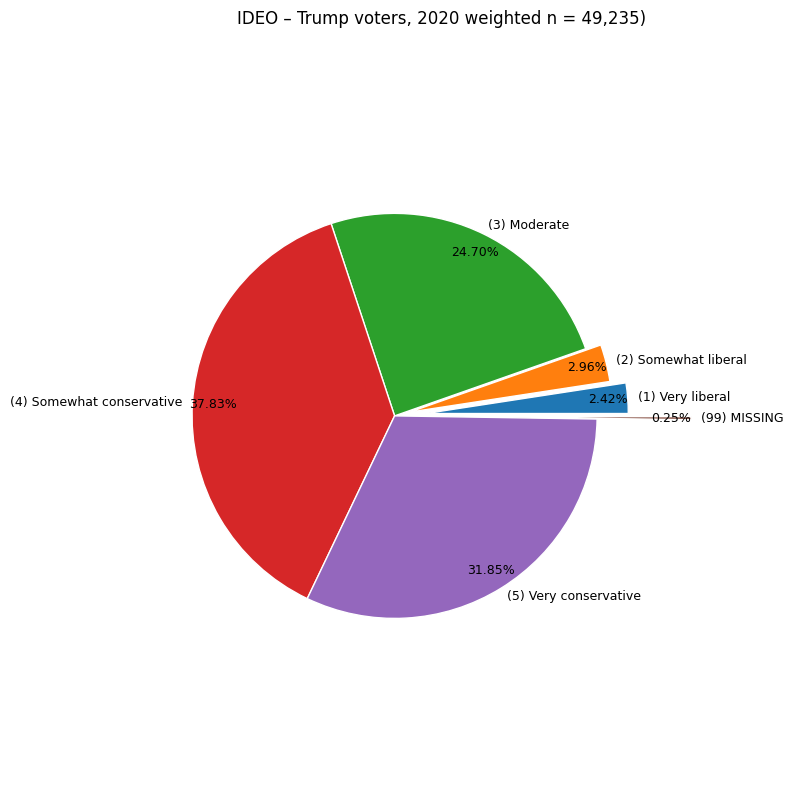

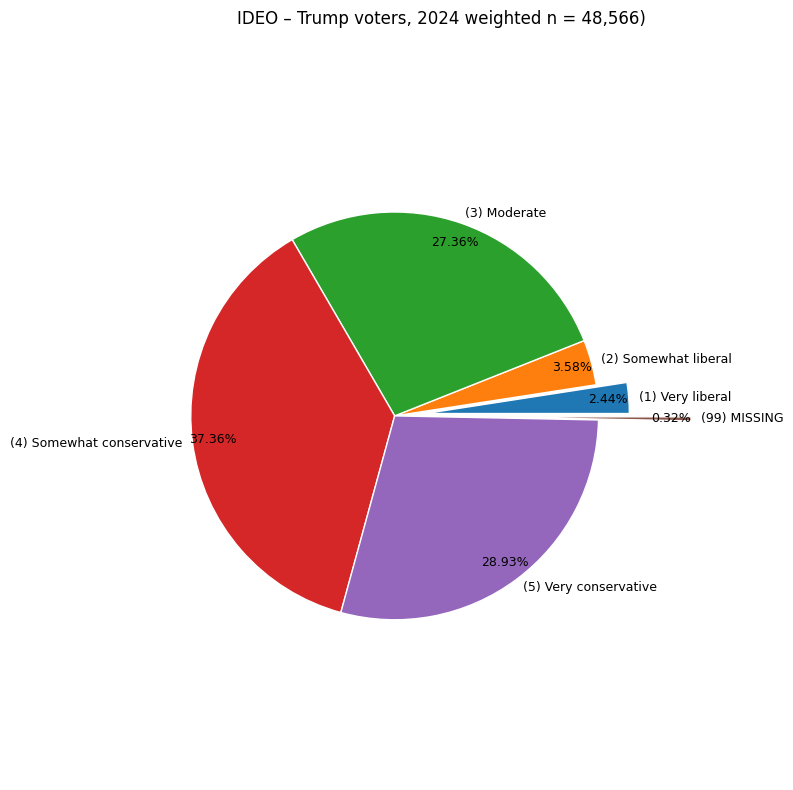

In [9]:
# core_columns = ["AGE65": age range,
#                "GENDER": gender (incl. non-binary),
#               "RACETH5": race (5 subgroups),
#                  "EDUC": highest level of education completed,
#                "RELIG4": present religion,
#                  "IDEO": liberal/conservative,
#             "PARTYFULL": identify as Dem/Rep,
#                "INCOME": annual income range,
#             "SIZEPLACE": area of living,
#                 "TRACK": perception on whether US is heading in the right track]
#
# Usage: describe_by(var: str; pick one from core_columns,
#               is_trump: bool; set to False to see result on non-Trump voters)

describe_by("IDEO", True)

While our core profile relies on variables common to both 2020 and 2024, several thematic items appear only in one cycle, some of them are also of interest. To examine these unique measures, we use a dedicated helper function that:

1. Filters the sample to likely voters who cast their ballot for Trump in the specified year.  
2. Applies the `FINALVOTE_NATIONAL_WEIGHT` to produce nationally representative estimates.  
3. Renders a single pie chart showing the weighted distribution of the selected year-specific variable.

By focusing each chart on the relevant Trump-voter subset, we gain clear insight into how election-specific issues shaped the MAGA electorate in each cycle.  

In [10]:
unique_cols2020 = set(f_cols2020).difference(common_cols)
print("Year-specific question for 2020 include:\n", unique_cols2020)

print("")

unique_cols2024 = set(f_cols2024).difference(common_cols)
print("Year-specific question for 2024 include:\n", unique_cols2024)

Year-specific question for 2020 include:
 {'VOTECOUNT', 'VOTE18CHOICE', 'IMPTSCOTUS', 'TRUMPEXTREMISM', 'COVIDGOV', 'VOTE16', 'TRUMPCHANGE', 'BIDENEXTREMISM', 'ISSUES2020', 'VOTE16CHOICE', 'NEC', 'RACISMUS', 'IMPTPROTESTS', 'BIDENCORRUPT', 'RACISMPOLICING', 'VOTEFRAUD', 'VOTE18', 'IMPTCOVID', 'IMPTSENATE', 'LV', 'VOTESUPPRES', 'FORMFLAG', 'COVID', 'COVIDTRUMP', 'TRUMPCORRUPT', 'COVIDFAUCI', 'LVA', 'IMPTECON'}

Year-specific question for 2024 include:
 {'COMMCONCERNCRIME', 'ISSUES2024', 'QVOTE2022', 'IMPTDEMOCRACY', 'IMPTINFLATION', 'AUTHTRUMP', 'BUDGETHOUSING', 'QPVVOTE20', 'ABORTIONIMPACTCAND', 'LEGIT', 'ABORTIONIMPACTTURNOUT', 'IMPTIMMIGRATION', 'IMPTASSASSIN', 'QPVVOTE22', 'COMMCONCERNHOUSING', 'TESTEDHARRIS', 'IMPTABORTION', 'COMMCONCERNCLIMATE', 'QVOTE2020', 'HOUSING', 'BUDGETHEALTH', 'TESTEDTRUMP', 'MAGA', 'AUTHHARRIS', 'IMPTFEMPRES', 'COMMCONCERNOPIOID', 'IMPTDTLEGAL', 'GETAHEAD', 'MENA', 'BUDGETGAS', 'PARTY5', 'BUDGETFOOD', 'IMPTSPEECH'}


In [11]:
def describe_year(var, is_trump):
    if is_trump:
        df_sets = [df20_trump, df24_trump]
    else:
        df_sets = [df20_other, df24_other]

    year = 2024 if var in f_cols2024 else 2020
    df = df_sets[0] if year == 2020 else df_sets[-1]
        
    tbl = tidy_share(df, var, year=year)
    
    display(tbl.sort_values(["year", "category"]).reset_index(drop=True))

    subtbl = tbl.sort_values("pct", ascending=True)
    explode = [0.5 - p / 7 if p < 3.5 else 0 for p in subtbl["pct"]]
    
    fig, ax = plt.subplots(figsize=(8, 8))
    wedges, texts, autotexts = ax.pie(subtbl["pct"],
                                      labels=subtbl["category"],
                                      explode=explode,
                                      autopct=lambda pct: f"{pct:.2f}%",
                                      pctdistance=0.9, # percentage labels closer to centre
                                      labeldistance=1.05, # category names pushed outside
                                      startangle=0,
                                      counterclock=True,
                                      wedgeprops=dict(linewidth=1, edgecolor="white"),
                                      textprops=dict(size=9)
                                     )

    if is_trump:
        ax.set_title(f"{var} – Trump voters, {year} weighted n = {subtbl['weighted_n'].sum():,.0f})", pad=20)
    else:
        ax.set_title(f"{var} – non-Trump voters, {year} weighted n = {subtbl['weighted_n'].sum():,.0f})", pad=20)
    ax.axis("equal")
    plt.tight_layout()
    plt.show()

The designer function `describe_year(var, is_trump=True)` can be applied to both 2024-only items and 2020-only items. Similar as above, this section is also interactive.

year                          category  weighted_n    pct
0  2024     (1) Yes, legitimately elected       16512  34.00
1  2024  (2) No, not legitimately elected       31025  63.88
2  2024                      (99) MISSING        1029   2.12

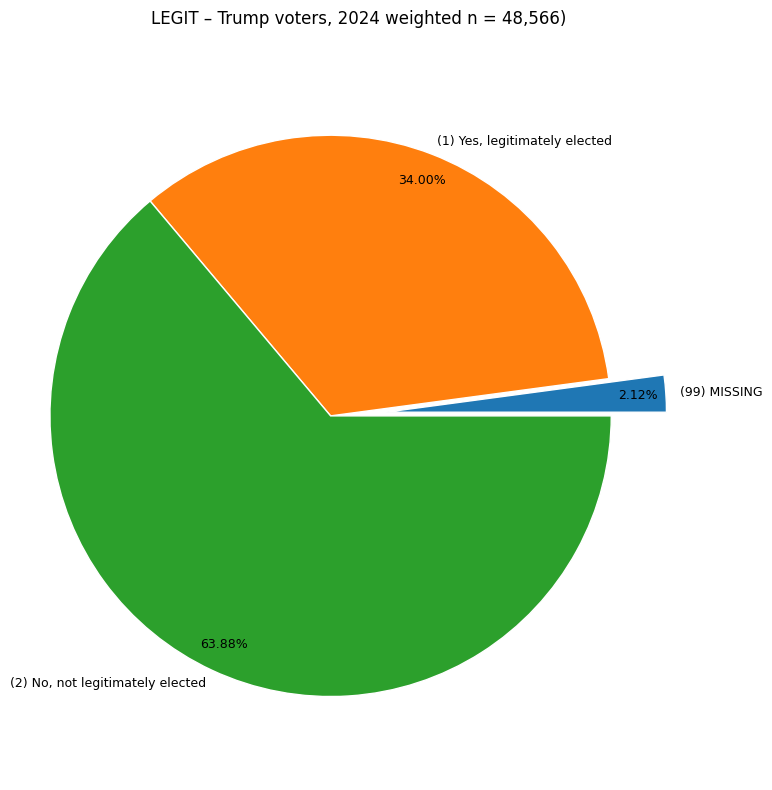

In [12]:
# 2020: ['RACISMPOLICING': whether racism in policing is an issue,
#              'RACISMUS': whether racism is an issue in US,
#                   'NEC': opinion on national economy,
#            'ISSUES2020': most important issue of 2020,
#          'VOTE16CHOICE': who was voted for in 2016,
#            'IMPTSENATE': importance of Senate control on vote decision,
#            'IMPTSCOTUS': importance of SCOTUS nominations on vote decision,
#              'IMPTECON': importance of economic downturn on vote decision,
#             'IMPTCOVID': importance of federal COVID response on vote decision,
#          'IMPTPROTESTS': importance of protests over police violence on vote decision,
#           'TRUMPCHANGE': whether Trump changed govt. for better,
#          'TRUMPCORRUPT': whether corruption under Trump as POTUS will be a problem,
#        'TRUMPEXTREMISM': whether Trump is overly tolerant of extremist groups,
#          'BIDENCORRUPT': whether corruption under Biden as POTUS will be a problem,
#        'BIDENEXTREMISM': whether Biden is overly tolerant of extremist groups,
#                 'COVID': whether COVID in US is under control,
#            'COVIDFAUCI': approval of Dr. Anthony Fauci's handling of COVID,
#            'COVIDTRUMP': approval of Trump's handling of COVID,
#             'VOTECOUNT': whether confident that votes be counted accurately]
#
# 2024: ['IMPTABORTION': importance of abortion policy on vote decision,,
#       'IMPTDEMOCRACY': importance of future of democracy on vote decision,
#          'IMPTSPEECH': importance of future of free speech on vote decision,
#       'IMPTINFLATION': importance of cost of living on vote decision,
#     'IMPTIMMIGRATION': importance of US-Mexico border situation on vote decision,
#         'IMPTFEMPRES': importance of Harris as first female POTUS on vote decision,
#         'IMPTDTLEGAL': importance of legal case against Trump on vote decision,
#        'IMPTASSASSIN': importance of Trump assassination attempt on vote decision,
#          'ISSUES2024': most important issue of 2024,
#  'COMMCONCERNCLIMATE': if concerned about climate change,
#  'COMMCONCERNHOUSING': if concerned about housing cost,
#    'COMMCONCERNCRIME': if concerned about crime,
#   'COMMCONCERNOPIOID': if concerned about opioid usage,
#          'BUDGETFOOD': if concerned about food & groceries cost,
#           'BUDGETGAS': if concerned about petrol cost,
#        'BUDGETHEALTH': if concerned about healthcare cost,
#           'QVOTE2020': who was voted for in 2020,
#               'LEGIT': whether Biden 2020 victory was legit,
#         'TESTEDTRUMP': whether Trump's abilities were tested and had positive results,
#           'AUTHTRUMP': if concerned about US becoming authotarian over Trump,
#        'TESTEDHARRIS': whether Harris' abilities were tested and had positive results,
#          'AUTHHARRIS': if concerned about US becoming authotarian over Harris,
#             'HOUSING': home ownership,
#                'MAGA': self-identification as MAGA,
#            'GETAHEAD': household financial situation]

# Usage: describe_year(var: str; from either of the above lists,
#                 is_trump: bool)

describe_year("LEGIT", True)

### Voter retention visualization

Having implemented the 2020 vs 2024 Trump electorate visualizer on single-profile snapshots, we now interrogate the durability of Trump support, by examining how respondents' retrospective 2016 and 2020 vote choice maps onto their actual 2020 and 2024 presidential vote. This longitudinal view uncovers both steadfast loyalty and shifts in allegiance within the electorate. More simply put, we aim to answer the following questions:

> How did respondents' claimed 2020 vote choices map onto their *actual* 2024 presidential vote?
> That is, who stayed with Trump? who switched to Dems or a third candidate?

While a traditional cross-tabulation can enumerate transitions, a [Sankey diagram](https://developers.google.com/chart/interactive/docs/gallery/sankey) encodes each flow's magnitude as its width, making relative sizes immediately apparent and preserving every category from third-party picks to non-voters in a single, coherent graphic. Again by multiplying each link by the `FINALVOTE_NATIONAL_WEIGHT`, we scale the diagram to reflect national population shares rather than raw respondent counts, aligning our visualization with AP's methodology.



Additionally, on inspecting the raw statistics for `QVOTE2020` it is discovered that $~24 %$ respondents did not answer this question, leading to the answer appearing as `NaN`. This is due to the procedures employed by AP-NORC: only those answered "I voted back in 2020" could proceed to fill out their choices. Due to statistical significance of the ratio, instead of silently dropping this group we record these `NaN` as an explicit "didn't vote" label, differentiating it from being simply missing.

The code that follows constructs weighted transition counts between 2020 and 2024 vote categories and renders them as a Sankey diagram, illuminating magnitudes of retention, defection, and non-participation.  

In [13]:
import plotly.io as pio
import plotly.offline as pyo
import plotly.graph_objects as go

# Allows interactive Sankey to be displayed within the notebook
pyo.init_notebook_mode()
pio.renderers.default = "notebook_connected"

# Same label is present in the 2020 data
no_vote_label = "(4) Did not vote"

def sankey_cross(df, src, dst = "PRESVOTE", drop_missing=True):
    if src not in df.columns:
        raise KeyError(f"The key {src} is not present within the specified DataFrame.")
    weight = "FINALVOTE_NATIONAL_WEIGHT"
    # load data
    tmp = df.copy()

    year = 2024 if "(1) Kamala Harris" in tmp["PRESVOTE"].unique().tolist() else 2020

    tmp[src] = tmp[src].fillna(no_vote_label) if src == "QVOTE2020" else tmp[src].fillna(unified_label)
    tmp[dst] = tmp[dst].fillna(unified_label)
    
    # strip numeric prefixes, handle NaNs
    for col in (src, dst):
        tmp[col] = tmp[col].str.replace(r"^\(\d+\)\s*", "", regex=True)

    # optional filtering of "missing" responses
    if drop_missing:
        tmp = tmp[(tmp[dst] != "MISSING") & (tmp[src] != "MISSING")]

    # weighted cross-tab
    flows = tmp.groupby([src, dst], observed=True)[weight].sum().reset_index()
    tot_w = flows[weight].sum()

    flows["src_lbl"] = src + ": " + flows[src]
    flows["dst_lbl"] = dst + ": " + flows[dst]
    
    # Build node list and map to integer ids
    nodes = pd.Series(pd.concat([flows["src_lbl"], flows["dst_lbl"]]).unique())
    node_id = {name: i for i, name in nodes.items()}
    flows["src_id"] = flows["src_lbl"].map(node_id)
    flows["dst_id"] = flows["dst_lbl"].map(node_id)
    
    # Sankey
    fig = go.Figure(data=[go.Sankey(arrangement="snap",
                                    node=dict(label=nodes,
                                              pad=15,
                                              thickness=15),
                                    link=dict(source=flows["src_id"],
                                              target=flows["dst_id"],
                                              value=flows[weight].round(2)))])
    
    fig.update_layout(title_text=f"{src} -> {dst} ({year}), all likely voters, weighted", font_size=11, width=900, height=500)
    fig.show()

In [14]:
# DataFrames to choose from: [df20_lv, df24_lv].
# Usage: sankey_cross(df: dataframe,
#                    src: str; the key within that year to query for (see previous interactive cell),
#                    dst: str; defaults to PRESVOTE, can be switched to anything
#           drop_missing: bool; defaults to True, whether to exclude "MISSING" items)

sankey_cross(df20_lv, "VOTE16CHOICE")
sankey_cross(df24_lv, "QVOTE2020")

A fallback using DataFrame tables, should the JavaScript-based `plotly` plotting fails to show, is also supplied.

In [15]:
def loyalty_table(df, src, dst, drop_missing=True):
    tmp = df.copy()
    
    # strip numeric prefixes
    tmp[src] = tmp[src].fillna(no_vote_label) if src == "QVOTE2020" else tmp[src].fillna(unified_label)
    tmp[src] = tmp[src].str.replace(r'^\(\d+\)\s*', '', regex=True)
    tmp[dst] = tmp[dst].fillna(unified_label)
    tmp[dst] = tmp[dst].str.replace(r'^\(\d+\)\s*', '', regex=True)

    if drop_missing:
        tmp = tmp[(tmp[src] != "MISSING") & (tmp[dst] != "MISSING")]
    
    tab = (tmp.groupby([src, dst], observed=True)["FINALVOTE_NATIONAL_WEIGHT"].sum().unstack(fill_value=0))
    pct = tab.div(tab.sum(axis=1), axis=0).round(3) * 100
    return pct.reset_index()

loy16_20 = loyalty_table(df20_lv, "VOTE16CHOICE", "PRESVOTE")
loy20_24 = loyalty_table(df24_lv, "QVOTE2020", "PRESVOTE")
display(loy16_20); display(loy20_24)

PRESVOTE     VOTE16CHOICE  Another candidate  Donald Trump  Joe Biden
0            Did not vote                2.3          41.2       56.5
1            Donald Trump                0.9          92.8        6.3
2         Hillary Clinton                0.5           3.4       96.0
3            Someone else               15.0          27.7       57.3

PRESVOTE     QVOTE2020  Another candidate  Donald Trump  Kamala Harris
0         Did not vote                2.0          50.4           47.6
1         Donald Trump                0.8          95.4            3.8
2            Joe Biden                1.2           4.5           94.4
3         Someone else               27.2          34.5           38.3

The graphs above confirm that voter loyalty across presidential cycles is extraordinarily high for both major parties. Among those who supported Trump in 2016, over 92 % remained in his camp in 2020, and among 2020 Biden backers, over 94 % stayed with the Democratic ticket in 2024. Defections occur only on the order of a few percentage points: roughly 6 % of 2016 Trump voters shifted to Biden in 2020, and only 4 % of 2020 Biden voters moved to Trump in 2024.

These patterns underscore the notable strength of partisan identity in U.S. presidential elections. With fewer than one in ten voters switching sides between cycles, electoral campaign efforts e.g. persuasion efforts alone are unlikely to sway more than a sliver of the electorate. Instead, meaningful change in election outcomes may depend more on mobilizing nonvoters, reengaging disaffected segments, or expanding the pool of likely voters.

### Profile Inter-association

Next, we attempt to establish an outline on how the ten "core" profile variables (age, gender, race, etc.) relate to one another and to `PRESVOTE`, in order to potentially uncover a preliminary indicator for accurately predicting voter preference. This baseline should identify variable pairs with the strongest associations or potential redundancy, assess whether demographics and basic attitudinal measures alone can distinguish partisan blocs, and provides a baseline gauge of association strength if more elaborate predictive models are to be evaluated.

For this, we implement a Cramer's V matrix, visualized as a heat map. When multiple categorical features (e.g. `RACETH5`, `PARTYFULL`, `GENDER`) are present and the goal is to understand which pairs move together, Cramer's V offers a quantitative, normalized measure of association, for it's:
1) based on $\chi^2$ statistic; for any two categorical variables, a contingency table tallies counts in each category-pair cell. The classic $\chi^2$ test then assesses whether the observed counts deviate from what is expected under independence, with larger $\chi^2$ hinting at stronger association, and
2) normalized to $[0, 1]$; as raw $\chi^2$ depends on sample size and table dimensions, Cramer's V rescales $\chi^2$ to lie between 0 (no association) and 1 (perfect association), via
\begin{align*}
V = \sqrt{\frac{\chi^2}{N \times (k - 1)}}
\end{align*}
where $N$ is total sample size and $k$ is the smaller among "number of rows" or "number of columns", and
3) a matrix of pairwise values; by computing Cramer's V for every pair of categorical variables, the process produces a symmetric "association matrix", with diagonal entries being 1 (a variable is perfectly "associated" with itself), and off-diagonals telling which pairs exhibit strong versus weak relationships.

By using Cramer's V, it is easier to spot highly correlated and potentially redundant or causal variables (e.g. two categorical columns that essentially encode the same information). Additionally, unlike correlation coefficients for continuous data, Cramer's V doesn't assume normality or linearity, it simply relies on counts - and by incorporating the `FINALVOTE_NATIONAL_WEIGHT` into each contingency table, we ensure that the resulting heatmap reflects national‐level relationships rather than raw respondent counts.

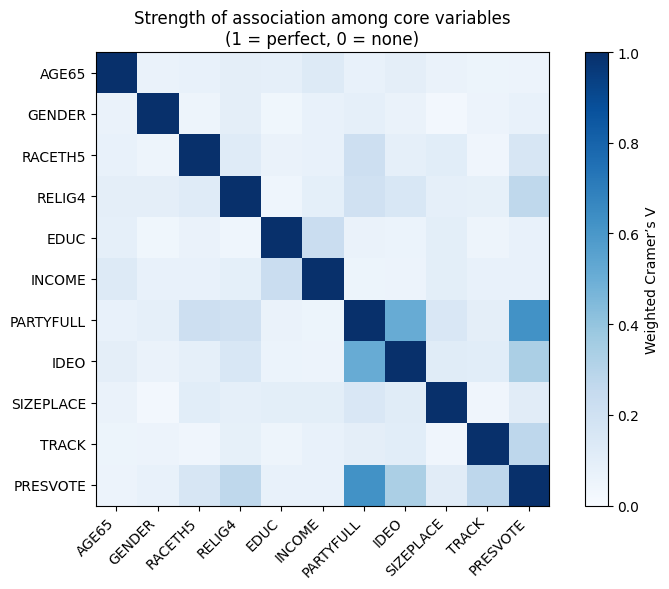

In [16]:
from itertools import combinations

def cramer(df, var_list, target="PRESVOTE"):
    df[target] = df[target].str.replace(r"^\(\d+\)\s*", "", regex=True)
    for v in var_list:
        df[v] = df[v].str.replace(r"^\(\d+\)\s*", "", regex=True)

    def weighted_cramers_v(x, y, w):
        # 2-way weighted contingency table
        ct = pd.crosstab(x, y, w, aggfunc="sum").fillna(0).values
        n = ct.sum()
        chi2 = ((ct - np.outer(ct.sum(1), ct.sum(0))/n) ** 2 / (np.outer(ct.sum(1), ct.sum(0)) / n)).sum()
        k, r = ct.shape
        return np.sqrt(chi2 / (n * (min(k, r) - 1)))
    
    # build symmetric matrix
    mat = pd.DataFrame(index=var_list + [target],
                       columns=var_list + [target], dtype=float)
    for a, b in combinations(mat.index, 2):
        v = weighted_cramers_v(df[a], df[b], df["FINALVOTE_NATIONAL_WEIGHT"])
        mat.loc[a, b] = mat.loc[b, a] = v
    np.fill_diagonal(mat.values, 1.0)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(mat, cmap="Blues", vmin=0, vmax=1)
    ax.set_xticks(range(len(mat))); ax.set_xticklabels(mat.columns, rotation=45, ha="right")
    ax.set_yticks(range(len(mat))); ax.set_yticklabels(mat.index)
    fig.colorbar(im, ax=ax, label="Weighted Cramer’s V")
    plt.title("Strength of association among core variables\n(1 = perfect, 0 = none)")
    plt.tight_layout()
    
    plt.show()

# variables asked of everyone, both years
base_vars = ["AGE65", "GENDER", "RACETH5", "RELIG4",
             "EDUC", "INCOME", "PARTYFULL", "IDEO",
             "SIZEPLACE", "TRACK"]

df_all = pd.concat([df20_lv, df24_lv], ignore_index=True)

cramer(df_all, base_vars)

On completion, minimal correlation except for `PARTYFULL` and `IDEO` vs `PRESVOTE` are found. Partisan affiliation, at ~ 0.5, is the single strongest predictor, as expected. Position on the ideology spectrum follows at ~ 0.35, showing high collinearity with party ID - hinting at potential redundancy. All other variables exhibit minimal signal in pairwise summaries, indicating that two-variable associations alone cannot uncover deeper structure.

Given the multiple categorical fields, another way is to try and uncover clusters of observations, across a multitude of variables. For this purpose, we turn to an unsupervised machine learning pipeline - "UMAP with HDBSCAN" - to discover latent groupings across our ten core features. This approach allows us to explore intrinsic data structure without imposing preconceived labels, a powerful tactic in modern exploratory data science.

Since we begin with multi-categorical data, which by nature often explodes in dimensionality, a common tactic is to employ [Uniform Manifold Approximation and Projection](https://arxiv.org/abs/1802.03426) (UMAP) to try and reduce data complexity with minimal loss. This is a dimension reduction technique that finds a uniformly distributed manifold within a low-dimensional embedding (usually 2D or 3D) that preserves local neighbor relations & topological structure from a high-dimensional sparse space under a chosen metric (e.g., Hamming or Jaccard); perfect for usage within this scenario, as it captures non-linear structure, scales efficiently to large samples, is (relatively) fast to compute on large sets of data and and yields intuitive visual output for human interpretation.

Following the completion of UMAP, we use [Hierarchical Density-Based Spatial Clustering of Applications with Noise](https://link.springer.com/chapter/10.1007/978-3-642-37456-2_14) (HDBSCAN) to build a hierarchy of density-based clusters on the UMAP embedding and extracts the most stable groupings - as clusters, once formed from subtle combinations of categories, can no longer be detected through simpler methods e.g. pairwise tables. Unlike k-means, it requires no pre-specified cluster count up front and automatically labels points that do not fit any dense region as "noise", filtering out outliers and focusing on coherent segments.

We parameterize UMAP with:
- `n_neighbors=20` to balance local vs. global structure,
- `min_dist=0.3` for controlling cluster tightness,
- `metric='jaccard'` to ensure suitability for binary/categorical dummy-encoded inputs,
- `random_state=int("01909412")` for reproducibility.

HDBSCAN is configured with
- `min_cluster_size=500` to ensure clusters are both meaningful and robust,
- `metric="euclidean"` on the 2D UMAP coordinates,
- `cluster_selection_method="eom"` to extract the most stable clusters.

The function `UMAP_HDBSCAN_clustering` dummy-encodes our base variables plus `PRESVOTE`, fits UMAP (approximately 9 min runtime), applies HDBSCAN to the resulting 2D embedding, and attaches a `cluster` label (with -1 for noise) to each respondent. The scatterplot of UMAP coordinates colored by cluster will immediately reveal the latent blocs that pairwise summaries cannot detect.

> Run `python -m pip install umap-learn` (not `umap`) in terminal for the up-to-date UMAP package.

UMAP modelling step time elapsed: 548.24 seconds.


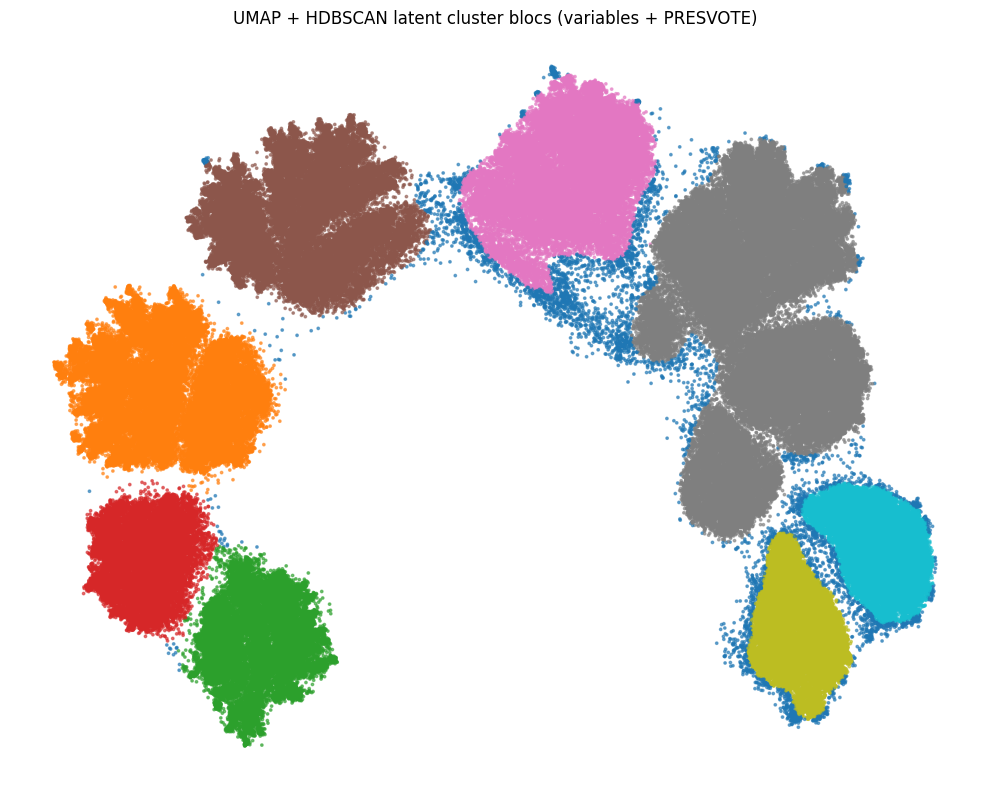

In [17]:
import umap.umap_ as umap
from scipy import sparse
import hdbscan
import warnings
import time

warnings.simplefilter(action='ignore')

def UMAP_HDBSCAN_clustering(df, vars_list, target_metric="PRESVOTE", out=False):
    seed = int("01909412")
    
    X = pd.get_dummies(df[vars_list + [target_metric]], drop_first=False).astype(int)
    X_csr = sparse.csr_matrix(X.values)
    
    # UMAP with Jaccard metric
    umap_model = umap.UMAP(metric="jaccard",
                           n_neighbors=40, min_dist=0.4,
                           random_state=seed, n_jobs=-1) # n_jobs=-1 to use all cores
    
    start = time.time()
    embed = umap_model.fit_transform(X_csr, y=None)
    end = time.time()
    print(f"UMAP modelling step time elapsed: {end - start:.2f} seconds.")
    
    # HDBSCAN on the 2-D embedding
    hdb = hdbscan.HDBSCAN(min_cluster_size=500, metric="euclidean",
                          cluster_selection_method="eom", prediction_data=False).fit(embed)

    tmp = df.copy()
    tmp["cluster"] = hdb.labels_ # index -1 for noise points
    
    # visual check
    plt.figure(figsize=(10, 8))
    plt.scatter(embed[:, 0], embed[:, 1], s = 3, c = tmp["cluster"],
                cmap = "tab10", alpha = 0.6, rasterized = True)
    plt.title(f"UMAP + HDBSCAN latent cluster blocs (variables + {target_metric})")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    if out:
        return tmp

df_all_clustered = UMAP_HDBSCAN_clustering(df_all, base_vars, out=True)

In [18]:
# profile clusters
def modal_profile(df, var, k, top=3):
    sub = df[df["cluster"] == k]
    if var == "INCOME":
        # avoid HTML display as LaTeX
        sub[var] = sub[var].str.replace(r"\$(?=\d)", "\\$", regex=True)
    w = sub["FINALVOTE_NATIONAL_WEIGHT"]
    tab = sub[var].str.replace(r"^\(\d+\)\s*", "", regex=True).groupby(sub[var]).apply(lambda s: w.loc[s.index].sum()).sort_values(ascending=False)
    return tab.head(top).index.tolist()

summary_rows = []

for k in sorted(df_all_clustered["cluster"].unique()):
    sub = df_all_clustered.loc[df_all_clustered["cluster"] == k]
    share = sub["FINALVOTE_NATIONAL_WEIGHT"].sum() / df_all_clustered["FINALVOTE_NATIONAL_WEIGHT"].sum()
    trump = (sub["PRESVOTE"] == "Donald Trump").mul(sub["FINALVOTE_NATIONAL_WEIGHT"]).sum() / sub["FINALVOTE_NATIONAL_WEIGHT"].sum()

    row = {"cluster" : k,
           "share %" : round(share * 100, 1),
           "Trump %" : round(trump * 100, 1)}

    # add modal category for each baseline variable (skip noise cluster –1)
    if k != -1:
        for var in base_vars:
            row[var] = modal_profile(df_all_clustered, var, k, 1)[0]

    summary_rows.append(row)

cluster_tbl = pd.DataFrame(summary_rows).set_index("cluster").sort_index()

pd.set_option('display.html.use_mathjax', False)
display(cluster_tbl.style.format({"share %": "{:.1f}", "Trump %": "{:.1f}"}))

**Immediate results:**

| Cluster         | Pop-share | Trump vote |
|-----------------|-----------|------------|
| −1 (noise)      |   1.7%    |    9.1%    |
| 0               |  15.0%    |   92.3%    |
| 1               |  10.8%    |   95.4%    |
| 2               |   9.3%    |   97.0%    |
| 3               |  14.7%    |   90.7%    |
| 4               |  10.6%    |    1.6%    |
| 5               |  25.6%    |    1.6%    |
| 6               |   5.8%    |    3.8%    |
| 7               |   6.5%    |    2.5%    |

Clusters 0 to 3 collectively capture about half of the electorate, each with over 90 % Trump support, distinguished only by subtle demographic and mood differences (age,  income, optimism). Clusters 4 to 7 likewise form Democratic-leaning blocs with near-zero Trump support, with minimal variation on ideology, religion and outlook. The small noise cluster (−1) is heterogeneous and largely non-Trump.

This core‐variable clustering reproduces the partisan divide but uncovers no further true "swing" groups; demographics and ideology alone separate camps without revealing within-party factions. To dissect the heterogeneity of the MAGA base (e.g., pro-gun vs. veteran vs. LGBT supporters), we now pivot to form-specific UMAP + HDBSCAN analyses on the rotating sub-questionnaires bu utilizing the same code pipelines, where issue-salience variables could uncover the attitudinal blocs that core demographics cannot.

In [19]:
import seaborn as sns
from collections import OrderedDict

def subform_analysis(df, form_vars, add_vars=[]):
    var_set = form_vars + add_vars + ["PRESVOTE", "FINALVOTE_NATIONAL_WEIGHT"]
    if "MAGA" in df.columns and "MAGA" not in var_set:
        var_set.append("MAGA")

    mask = df[[v for v in var_set if v != "FINALVOTE_NATIONAL_WEIGHT"]].notna().all(axis=1)
    df_sub = df.loc[mask, var_set].copy()

    for v in var_set:
        df_sub[v] = df_sub[v].astype(str).str.replace(r"^\(\d+\)\s*", "", regex=True)
    df_sub["FINALVOTE_NATIONAL_WEIGHT"] = pd.to_numeric(df_sub["FINALVOTE_NATIONAL_WEIGHT"], errors="coerce")

    def weighted_cramers_v(x, y, w):
        # 2-way weighted contingency table
        ct = pd.crosstab(x, y, w, aggfunc="sum").fillna(0).values
        n = ct.sum()
        chi2 = ((ct - np.outer(ct.sum(1), ct.sum(0))/n) ** 2 / (np.outer(ct.sum(1), ct.sum(0)) / n)).sum()
        k, r = ct.shape
        return np.sqrt(chi2 / (n * (min(k, r) - 1)))

    var_set.remove("FINALVOTE_NATIONAL_WEIGHT")
    idx = var_set
    V = pd.DataFrame(np.eye(len(idx)), index=idx, columns=idx)
    for a, b in combinations(idx, 2):
        v = weighted_cramers_v(df_sub[a], df_sub[b], df_sub["FINALVOTE_NATIONAL_WEIGHT"])
        V.loc[a, b] = V.loc[b, a] = v

    plt.figure(figsize=(12, 10))
    sns.heatmap(V, cmap="Blues", vmin=0, vmax=1,
                square=True, cbar_kws=dict(label="Weighted Cramer's V"))
    plt.title("Inter-item association (form-specific)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    tmp = UMAP_HDBSCAN_clustering(df_sub, var_set, out=True)

    def cluster_summary_table(df_clustered, var_list, weight="FINALVOTE_NATIONAL_WEIGHT"):
        out = OrderedDict()
        total_w = df_clustered["FINALVOTE_NATIONAL_WEIGHT"].sum()
        
        def modal(series, w):
            return series.groupby(series).apply(lambda idx: w.loc[idx.index].sum()).sort_values(ascending=False).index[0]
    
        for k in sorted(df_clustered["cluster"].unique()):
            sub = df_clustered[df_clustered["cluster"] == k]
            w_sub = sub["FINALVOTE_NATIONAL_WEIGHT"]
    
            col = OrderedDict()
            col["share %"] = round(100 * w_sub.sum() / total_w, 1)
            col["Trump %"] = round(100 * ((sub["PRESVOTE"] == "Donald Trump").mul(w_sub).sum() / w_sub.sum()), 1)
            for v in var_list:
                col[v] = modal(sub[v], w_sub)
            out[f"Cluster {k}"] = col
            
        df_out = pd.DataFrame(out)
        return df_out

    summary = cluster_summary_table(tmp, var_set)
    display(summary)

In [20]:
# 2020 specific, all-encompassing
form_all_20 = ['RACISMPOLICING', 'RACISMUS',
               'NEC', 'ISSUES2020', 'VOTE16CHOICE',
               'IMPTSENATE', 'IMPTSCOTUS', 'IMPTECON', 'IMPTCOVID', 'IMPTPROTESTS',
               'TRUMPCHANGE', 'TRUMPCORRUPT', 'TRUMPEXTREMISM',
               'BIDENCORRUPT', 'BIDENEXTREMISM',
               'COVID', 'COVIDFAUCI', 'COVIDTRUMP',
               'VOTECOUNT']

# 2024 specific, all-encompassing
form_all_24 = ['IMPTABORTION', 'IMPTDEMOCRACY', 'IMPTSPEECH', 'IMPTINFLATION',
               'IMPTIMMIGRATION', 'IMPTFEMPRES', 'IMPTDTLEGAL', 'IMPTASSASSIN',
               'ISSUES2024', 'COMMCONCERNCLIMATE', 'COMMCONCERNHOUSING',
               'COMMCONCERNCRIME', 'COMMCONCERNOPIOID',
               'BUDGETFOOD', 'BUDGETGAS', 'BUDGETHEALTH',
               'QVOTE2020', 'LEGIT',
               'TESTEDTRUMP', 'AUTHTRUMP', 'TESTEDHARRIS', 'AUTHHARRIS',
               'HOUSING', 'GETAHEAD']

# 2020, form 1
form1_20 = ["BETTERHANDLEECON", "BETTERHANDLECOVID", "BETTERHANDLEPOLICECJS",
            "BETTERHANDLETRADE", "BETTERHANDLEENERGY", "BETTERHANDLESCOTUS",
            "ABORTION", "ROEVWADE",
            "POLICE", "CRIMJUSTICE", "SAFETERROR", "SAFECRIME", "SAFECYBER",
            "MARRIED", "BORNAGAIN", "ATTENDANCE",
            "LGBT"]
# 2020, form 2
form2_20 = ["TIMEDECIDE", "FORCAND", "PRESAPP", "CONGRESSJOB",
            "IMPTUNITE", "IMPTSHAKEUP", "IMPTLOOKOUT",
            "TRUMPCARES", "TRUMPSTRONG", "TRUMPHONEST", "TRUMPSTANDSUP", "TRUMPMENTALCAP", "TRUMPHEALTH",
            "BIDENCARES", "BIDENSTRONG", "BIDENHONEST", "BIDENSTANDSUP", "BIDENMENTALCAP", "BIDENHEALTH",
            "FTVOTER"]
# 2020, form 3
form3_20 = ["FAVTRUMP", "FAVPENCE", "FAVBIDEN", "FAVHARRIS",
            "FAVREP", "FAVDEM",
            "USROLE", "TRUMPRUSSIA", "TRUMPCHINA", "TRUMPNKOREA",
            "CLIMATE", "GUNPOLICY", "INTERFERENCE",
            "VET", "GUNOWNER"]
# 2020, form 4
form4_20 = ["GETAHEAD", "GOVTDO", "GOVTANGR",
            "MASKS", "TARIFFS", "PUBLICOPT", "GOVREG", "IMMWALL", "GREENENERGY", "HEALTHLAW", "IMMDEPORT",
            "COVIDECON", "COVIDIMPACTEVENT", "COVIDIMPACTECON", "COVIDIMPACTDIED", "UNIONHH"]
# 2024, form 1
form1_24 = ["TIMEDECIDE", "UPHEAVAL",
            "TRUMPLOOKSOUT", "TRUMPSTRONG", "TRUMPHONEST", "TRUMPMENTALCAP",
            "TRUMPCHANGE", "TRUMPCAPABLE", "TRUMPCHARACTER", "TRUMPPOLICY",
            "HARRISLOOKSOUT", "HARRISSTRONG", "HARRISHONEST", "HARRISMENTALCAP",
            "HARRISCHANGE", "HARRISCAPABLE", "HARRISCHARACTER", "HARRISPOLICY",
            "SCOTUSJOB", "DOJJOB", "SECRETSERVICEJOB", "FEMAJOB", "GUNPOLICY",
            "VET", "GUN"]
# 2024, form 2
form2_24 = ["FAVTRUMP", "FAVHARRIS", "FAVBIDEN", "FAVDEM", "FAVREP", "FAVVANCE", "FAVWALZ", "FAVRFKJR",
            "ABORTION15WEEKS", "MARIJUANA", "GENDERAFFCARE", "STUDDEBT",
            "TRANSRIGHTS", "ABORTION", "HEALTHCOV", "PRESCRIPTION", "MEDDEBT", "VACCINES",
            "MARRIED", "PARENTUS",
            "CATOWNER", "DOGOWNER",
            "TIKTOKUSER", "BORNAGAIN", "LGBT"]
# 2024, form 3
form3_24 = ["VOTECOUNTNATL", "VOTESUPPRES", "VOTEFRAUD",
            "PRESAPP", "PRESAPPTRUMP",
            "CONGRESSJOB", "NEC",
            "EXTREMEHARRIS", "EXTREMETRUMP", "DEMSVIOLENCE", "REPSVIOLENCE",
            "JANSIXTH", "FTVOTER", "FORCAND"]
# 2024, form 4
form4_24 = ["RACISMUS", "RACISMPOLICING",
            "BETTERHANDLEECON", "BETTERHANDLEIMM", "BETTERHANDLEMIDEAST", "BETTERHANDLECLIMATE",
            "BETTERHANDLEABORTION", "BETTERHANDLEHEALTH", "BETTERHANDLETAXES", "BETTERHANDLECRIME",
            "GOVTDO", "UKRAINEAID", "ISRAELAID",
            "TARIFFS", "ASYLUM", "IMMDEPORT", "ENERGY",
            "UNION", "ATTENDANCE", "IMMIGRANTGEN"]

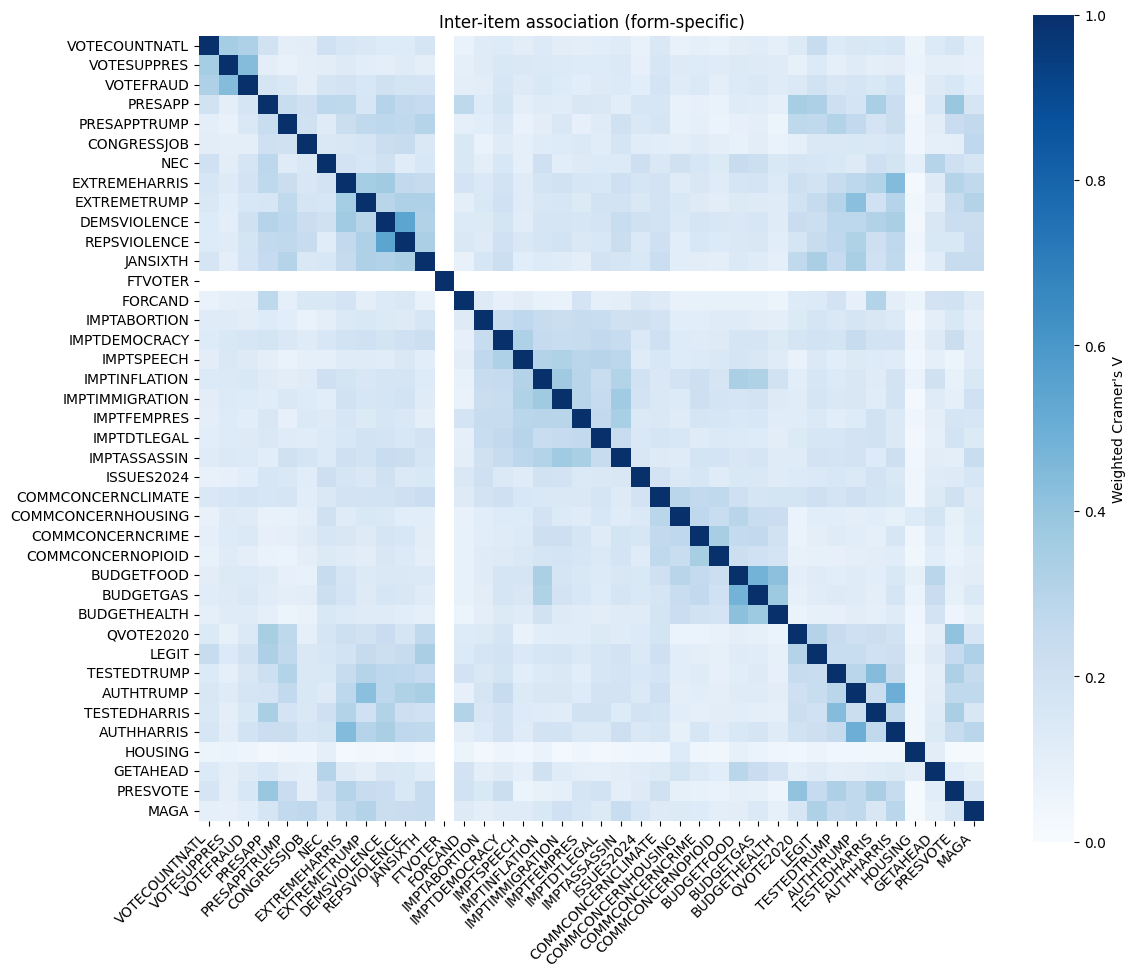

UMAP modelling step time elapsed: 18.54 seconds.


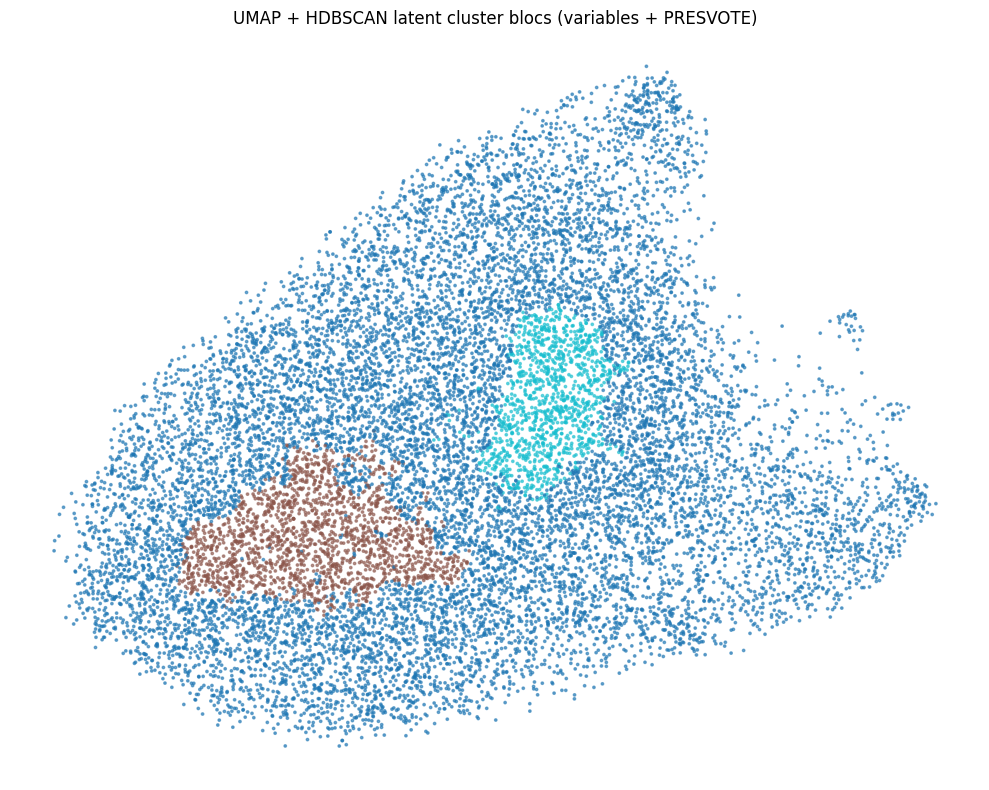

Cluster -1  \
share %                                                          81.9   
Trump %                                                           0.0   
VOTECOUNTNATL                                          Very confident   
VOTESUPPRES                                            Very confident   
VOTEFRAUD                                              Very confident   
PRESAPP                                              Somewhat approve   
PRESAPPTRUMP                                      Strongly disapprove   
CONGRESSJOB                                       Somewhat disapprove   
NEC                                                              Good   
EXTREMEHARRIS                                    Not at all concerned   
EXTREMETRUMP                                           Very concerned   
DEMSVIOLENCE                                            No, it is not   
REPSVIOLENCE                                               Yes, it is   
JANSIXTH                                                        A lot   
FTVOTER                                                            No   
FORCAND                                            For your candidate   
IMPTABORTION          An important factor, but not the most important   
IMPTDEMOCRACY                        The single most important factor   
IMPTSPEECH            An important factor, but not the most important   
IMPTINFLATION         An important factor, but not the most important   
IMPTIMMIGRATION       An important factor, but not the most important   
IMPTFEMPRES           An important factor, but not the most important   
IMPTDTLEGAL           An important factor, but not the most important   
IMPTASSASSIN                                             Not a factor   
ISSUES2024                                       The economy and jobs   
COMMCONCERNCLIMATE                                     Very concerned   
COMMCONCERNHOUSING                                     Very concerned   
COMMCONCERNCRIME                                   Somewhat concerned   
COMMCONCERNOPIOID                                  Somewhat concerned   
BUDGETFOOD                                             Very concerned   
BUDGETGAS                                          Somewhat concerned   
BUDGETHEALTH                                           Very concerned   
QVOTE2020                                                   Joe Biden   
LEGIT                                       Yes, legitimately elected   
TESTEDTRUMP                     Tested and delivered negative results   
AUTHTRUMP                                              Very concerned   
TESTEDHARRIS                    Tested and delivered positive results   
AUTHHARRIS                                       Not at all concerned   
HOUSING             Owned or being bought by you or someone in you...   
GETAHEAD                                               Holding steady   
PRESVOTE                                                Kamala Harris   
MAGA                                                               No   

                                                            Cluster 0  \
share %                                                          10.9   
Trump %                                                           0.0   
VOTECOUNTNATL                                          Very confident   
VOTESUPPRES                                            Very confident   
VOTEFRAUD                                              Very confident   
PRESAPP                                              Somewhat approve   
PRESAPPTRUMP                                      Strongly disapprove   
CONGRESSJOB                                       Somewhat disapprove   
NEC                                                              Good   
EXTREMEHARRIS                                    Not at all concerned   
EXTREMETRUMP                                           Very concerned   
DEMSVIOLENCE                               

In [21]:
# HOWTOUSE
# call subform_analysis(df, form_vars, add_vars) to show Carmer's V, UMAP-HDBSCAN and an interpretation of cluster profiles.
# df: pd.DataFrame, can be df{20/24}_{lv/trump/other}
# form_vars: list, can be form{1/2/3/4}_{20/24}
# add_vars: list, default [], can be form_all_{20/24}

subform_analysis(df24_other, form3_24, add_vars=form_all_24)

Across both our core‐variable and sub‐form‐specific UMAP + HDBSCAN analyses, we observe the same striking pattern: clusters cleanly separate Trump supporters from everyone else, but reveal almost no internal segmentation within the MAGA base. Even when we isolate a single thematic module (e.g. sub‐form 3) and re-run the embedding and clustering on all respondents, on Trump voters alone, or on non-Trump voters alone, the resulting blocs still coincide almost perfectly with vote choice.

This means two things:

1. Extreme opinion polarization. Highly publicized and politicized items, whether culture-war questions, policy priorities, or elite favorability, are already nearly binary along partisan lines. If a respondent answers "Yes" to one MAGA-aligned item, they almost invariably answer "No" to the opposing side's counterpart.  

2. Within-group homogenization. Because MAGA supporters share so many aligned attitudes, there is little residual variation on these survey questions to carve out distinct sub‐types. In effect, once the set is conditioned on `PRESVOTE == Trump`, the manifold collapses - everyone thinks the same way.

In sum, neither broad demographics nor rotating issue questions meaningfully distinguish "types" of MAGA voters. Instead, the data reveal a highly cohesive, polarized electorate in which attitudes across agendas move in lockstep. This extreme homogeneity suggests that to understand finer shades of MAGA support - to go beyond simple "for" versus "against" on issues - we must turn to more targeted hypothesis tests that can tease out the modest signals buried under this overwhelming partisan alignment.

### Hypothesis Testing: Stereotype Flags vs. MAGA Identity

Having found that neither broad demographics nor unsupervised clustering on core or sub-form variables meaningfully distinguishes sub-types of Trump supporters, we pivot to a targeted, flag-by-flag approach. Here, we ask: for each culturally salient question, does answering "Yes" (or "Strongly oppose" etc.) significantly increase or decrease a respondent's odds of self-identifying as MAGA?  

Shifting from unsupervised exploration to a targeted regression framework, we construct a binary outcome `is_maga` (1 if the respondent self-identifies as MAGA, 0 otherwise) and fit survey-weighted logistic models for each cultural "flag" question.  After excluding missing responses, we one-hot encode the remaining categories, use the alphabetically first level as the reference, and apply `FINALVOTE_NATIONAL_WEIGHT` as frequency weights in a binomial generalized linear model (GLM). Exponentiating the coefficients yields odds ratios (ORs) for each non-reference category versus baseline, with p-values testing deviation from OR = 1.

In [22]:
import statsmodels.api as sm

def stereotype_vs_maga(df, flags, only_display=True):

    tmp = df.copy()
    tmp["is_maga"] = (tmp["MAGA"] == "(1) Yes").astype(int)
    tables = {}

    MAX_CATS = 20
    
    def run_flag(df, flag):
        if df[flag].nunique(dropna=True) > MAX_CATS:
            print(f"-- skipping {flag} (>{MAX_CATS} unique values)")

        mask = (df[flag].notna() & df["FINALVOTE_NATIONAL_WEIGHT"].apply(float).notna())
    
        cleaned = df[flag].str.replace(r"^\(\d+\)\s*", "", regex=True)
    
        mask &= cleaned.ne("MISSING")
    
        sub = df.loc[mask, [flag, "is_maga", "FINALVOTE_NATIONAL_WEIGHT"]].copy()
        sub[flag] = cleaned.loc[mask]

        categories = sorted(sub[flag].unique())
        ref_cat = categories[0]

        X = pd.get_dummies(sub[flag], prefix=flag, drop_first=True, dtype=float)
        X = sm.add_constant(X)
        y = sub["is_maga"]
        w = pd.to_numeric(sub["FINALVOTE_NATIONAL_WEIGHT"], errors="coerce")
        
        fit = sm.GLM(y, X, family=sm.families.Binomial(), freq_weights=w).fit()
        tiny = np.finfo(float).tiny
        
        rows = []
        for term, coef, p in zip(X.columns[1:], fit.params[1:], fit.pvalues[1:]):
            rows.append({"flag": flag,
                         "category": term.split("_", 1)[1],
                         "OR": round(np.exp(coef), 2),
                         "p": f"{p:.2e}" if p != 0.0 else f"< {tiny:.2e}"})
        
        return pd.DataFrame(rows).set_index("category"), ref_cat

    for f in flags:
        tbl, ref = run_flag(tmp, f)
        tables[f] = tbl
        if only_display:
            print(f"\n### {f} (reference = '{ref}')\n")
            display(tbl)
            
    return tables

In [23]:
stereotypes = ["LGBT", "CATOWNER", "VET", "GUN", "BORNAGAIN", "MARIJUANA", "JANSIXTH", "ENERGY"]

_ = stereotype_vs_maga(df24_lv, stereotypes)


### LGBT (reference = 'No')



flag    OR         p
category                      
Yes       LGBT  0.35  7.54e-89


### CATOWNER (reference = 'No')



flag    OR         p
category                          
Yes       CATOWNER  1.06  3.78e-02


### VET (reference = 'No')



flag    OR         p
category                                                     
Yes, both me and someone in my household  VET  1.39  7.00e-04
Yes, myself                               VET  1.79  1.26e-49
Yes, someone in my household              VET  1.43  6.13e-25


### GUN (reference = 'No')



flag    OR          p
category                                                      
Yes, both me and someone in my household  GUN  3.23  1.21e-176
Yes, myself                               GUN  2.34  3.94e-160
Yes, someone in my household              GUN  1.76   1.43e-53


### BORNAGAIN (reference = 'No')



flag    OR            p
category                              
Yes       BORNAGAIN  2.94  < 2.23e-308


### MARIJUANA (reference = 'Somewhat favor')



flag    OR          p
category                                   
Somewhat oppose  MARIJUANA  1.52   3.35e-29
Strongly favor   MARIJUANA  0.75   6.11e-18
Strongly oppose  MARIJUANA  2.49  6.90e-134


### JANSIXTH (reference = 'A lot')



flag     OR            p
category                                 
None at all  JANSIXTH  40.28  < 2.23e-308
Some         JANSIXTH  10.11  < 2.23e-308


### ENERGY (reference = 'Focus on expanding production of fossil fuels, such as oil and gas')



flag    OR            p
category                                                                     
Focus on expanding use of alternative energy, s...  ENERGY  0.11  < 2.23e-308

Almost all odds ratios are highly significant (p << 0.001) with a few of them dipping below Python machine precision in magnitude (which are reported as `< 2.23e-308`), confirming that these stereotypical markers exhibit extremely strong associations with MAGA self-identification:

- LGBT identity is negatively associated (OR = 0.35, p = 7e-88) with MAGA, reflecting stereotypical under-representation.
- Veteran status raises MAGA odds by 39% if both respondent and household served (OR = 1.39, p = 7e-4), by 79% for the respondent alone (OR = 1.79, p = 1.3e-49), and by 43% if only someone else in the household served (OR = 1.43, p = 6.1e-25).
- Gun ownership, unsurprisingly emerges as one of the strongest predictors: owning guns personally plus in the household triples MAGA odds (OR = 3.23, p = 1.2e-176), personal ownership alone more than doubles them (OR = 2.34, p = 3.9e-160); even second hand exposure to household gun ownership can boost odds significantly (OR = 1.76, p = 1.4e-53).
- Marijuana legalisation exhibits a clear gradient. Relative to "Somewhat favor", those who "Somewhat oppose" are 52% more likely to be MAGA (OR = 1.52, p = 3.4e-29), and "Strongly oppose" raises odds by 149% (OR = 2.49, p = 6.9e-134), whereas "Strongly favor" reduces MAGA odds (OR = 0.75, p = 6.1e-18).
- Most strikingly, skepticism about the [January 6th](https://en.wikipedia.org/wiki/January_6_United_States_Capitol_attack) responsibilities is enormously predictive: compared to those who say Donald Trump should take "A lot" responsibilities, those who say he's only responsible in "Some" ways have *ten‐fold* higher MAGA odds (OR = 10.11, p < 2.2e-308), and those who say there are "None at all" have ***forty‐fold*** higher odds (OR = 40.28, p < 2.2e-308).
- Born-again Christianity also nearly triples MAGA odds (OR = 2.94, p < 2.2e-308).
- On energy policy, respondents preferring a shift toward alternative energy ("solar and wind") have only about one-tenth the odds of MAGA affiliation compared to those favoring fossil-fuel expansion (OR = 0.11, p < 2.2e-308).
- Finally, cat ownership (as suggested by J.D. Vance) carries only a modest positive association (OR = 1.06, p = 3.8e-2), and the high p-value suggests insignificance of correlation compared with other agendas.

These results demonstrate that, despite overwhelming polarization on issues across a highly polarized electorate, individual response choices on these culturally resonant flags still carry distinct, measurable power to distinguish MAGA identifiers. To aggregate these effects across a more comprehensive set of response levels, we will next collect log-odds ratios and p-values into a **volcano plot**, spotlighting the most potent predictors of MAGA support.

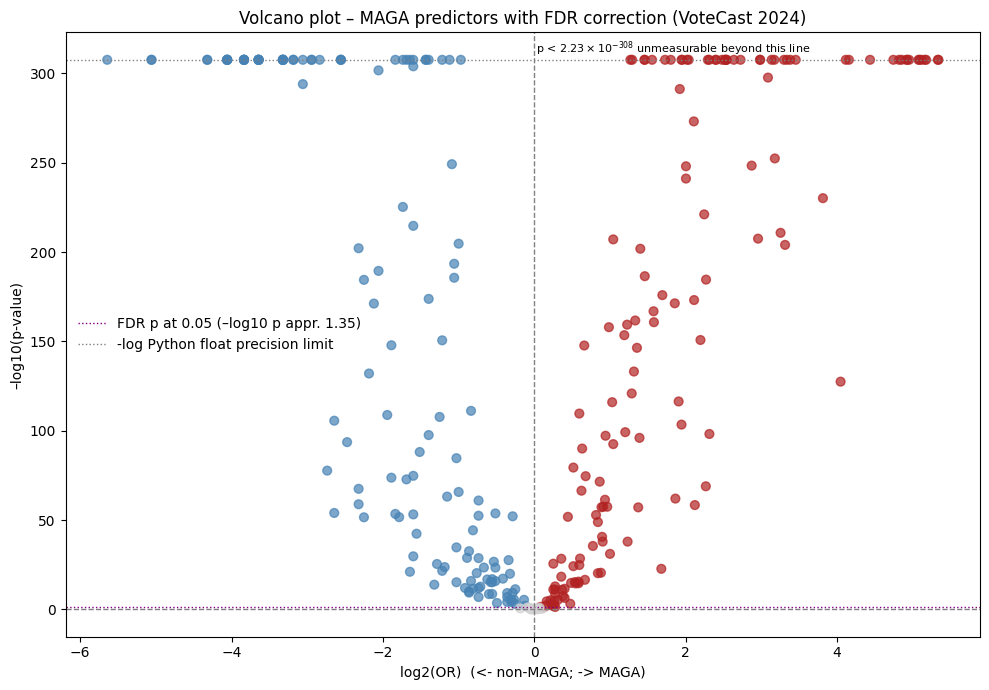

In [24]:
from statsmodels.stats.multitest import multipletests

volcano_rows = []

volcano_flags = base_vars + form_all_24 + form1_24 + form2_24 + form3_24 + form4_24

flag_tables = stereotype_vs_maga(df24_lv, volcano_flags, only_display=False)

for flag, tbl in flag_tables.items():
    for cat, row in tbl.iterrows():
        or_val = row["OR"]
        row["p"] = row["p"].replace("< ", "")
        p_val = float(row["p"])
        volcano_rows.append({"flag": flag,
                             "category": cat,
                             "p_val": p_val,
                             "log2OR": np.log2(or_val),
                             "-log10p": -np.log10(p_val)})

volcano = pd.DataFrame(volcano_rows)

# Benjamin-Hochberg false discovery rate
alpha = 5e-2
rejected, qvals, _, _ = multipletests(volcano["p_val"], alpha=alpha, method="fdr_bh")
volcano["q_val"] = qvals

# True if survives FDR <= 0.05
volcano["sig_FDR"] = rejected
volcano["color"] = np.where(volcano["sig_FDR"], np.where(volcano["log2OR"] > 0, "firebrick", "steelblue"), "lightgrey")

# horizontal line height for FDR cut-off (lowest –log10p still significant)
bh_cut = -np.log10(volcano.loc[volcano["sig_FDR"], "p_val"].max())

plt.figure(figsize=(10, 7))
plt.scatter(volcano["log2OR"], volcano["-log10p"], c=volcano["color"], s=40, alpha=0.7)

# FDR threshold lines
plt.axhline(0, ls="--", lw=1, color="grey")
plt.axhline(bh_cut, ls=":", lw=1, color="purple", label=f"FDR p at {alpha} (–log10 p appr. {bh_cut:.2f})")
plt.axhline(-np.log10(np.finfo(float).tiny), ls=":", lw=1, color="grey", label="-log Python float precision limit")
plt.axvline(0, ls="--", lw=1, color="grey")
plt.legend(loc="center left", frameon=False)

plt.xlabel(r"log2(OR)  (<- non-MAGA; -> MAGA)")
plt.ylabel(r"–log10(p-value)")
plt.text(0.02, 1-np.log10(np.finfo(float).tiny),
         r"p < $2.23 \times 10^{-308}$ unmeasurable beyond this line",
         fontsize=8, ha="left", va="bottom")
plt.title("Volcano plot – MAGA predictors with FDR correction (VoteCast 2024)")
plt.tight_layout()
plt.show()

Here, capped -log p values for points at the very top (along the top dashed line) represent p-values so small (p < `numpy.finfo(float).tiny`) that they slip under Python's floating-point precision. Although they are plotted at the same height, these categories differ in their true significance; the cap simply highlights that their p-values are effectively indistinguishable from zero at machine precision. Due to this indistinguishability, we suggest an alternative listing by OR alone to measure the top responses with highest odds ratios that would predict MAGA affiliation.

In [25]:
alpha_fdr = 0.05
top_n = 20

# keep predictors whose adjusted p-value survived the FDR cutoff
pro_maga = volcano.loc[(volcano["p_val"] <= alpha_fdr) & (volcano["log2OR"] > 0)].copy()

# rank by effect size (largest odds-ratio first)
pro_maga.sort_values("log2OR", ascending=False, inplace=True)
pro_maga["log2OR"] = pro_maga["log2OR"].apply(lambda x: 2 ** x)

# extract the top N rows and make a tidy view
top10 = pro_maga.head(top_n).loc[:, ["flag", "category", "log2OR", "p_val"]].rename(columns={"flag": "variable",
                                                                                    "category": "response",
                                                                                    "log2OR": "odds ratio",
                                                                                    "p_val": "p-value after FDR"})

display(top10.style.format({"odds ratio": "{:.2f}", "p-value after FDR": "{:.2e}"}))

The volcano plot above plots each response category's effect on MAGA self‐identification by combining its estimated effect size (log2 OR on the x-axis) with its statistical significance (-log10 p-value on the y-axis). Two distinct "branches" emerge: predictors strongly associated with MAGA (red points on the right) and those strongly associated with non-MAGA (blue points on the left), with virtually nothing of consequence in between. This visual pattern powerfully illustrates the extent of issue polarization in the electorate. A few caveats within the graph:

- By applying a False Discovery Rate (FDR) correction at alpha = 0.05 (purple dashed horizontal line), we focus on the most robust signals. The plot, as well as the table, show that culturally and personality-adjacent charged attitudes - on candidates, January 6th, pressing issues and more - produce some of the largest effect sizes and most extreme p-values, confirming that these issues reliably split voters along MAGA lines. The symmetry of the two horns underscores the mirror-image nature of partisan sentiment: what strongly predicts MAGA almost equally strongly predicts non-MAGA when reversed.  

- The near-complete absence of points around log2 OR ~ 0 and moderate -log p creates an empty middle section. This gap indicates that almost no response category has both a negligible effect size (OR ~ 1) and high significance. In other words, survey items rarely hover around "no association"; they either strongly predict MAGA vs. non-MAGA, or they do not survive the FDR threshold (and appear as light grey near the bottom).

In sum, the volcano plot succeeds in condensing hundreds of stereotype tests into a single, intuitive graphic that captures both the magnitude and certainty of each predictor’s association, and when combined with all above visualization efforts, lay bare statistically rather than anecdotally the deep fault lines of political polarization.

So, is there still the possibility for any form of partisan reconcilation?

### Searching for a common ground

To locate where MAGA and non-MAGA voters give (statistically) the same answer, if at all, we inherit the previous volcano plot pipeline to try and find a "consensus" zone. Previously, for each response category we estimated an odds-ratio (OR) predicting MAGA support and obtained an FDR-adjusted p-value, giving the self-indentifying direction (pro- vs. anti- MAGA) and the strength/significance; due to the nature of p-values obtained in practice, we keep only points with `log2OR`. Next, we clean the output by excluding core demographic variables (age, gender etc.) as only social agendas that can be acted on instead of immutable traits are of interest here; for every surviving flag-category pair we then compute the weighted national base (as we have done throughout this project) and sort them by weighted electorate count.

In [26]:
cg = volcano.loc[(volcano["p_val"] > 0) & (volcano["log2OR"].abs() < 0.5)]

# Show the 6 largest samples
cg_rows = []
for _, row in cg.iterrows():
    if row["flag"] in base_vars:
        continue
    f = row["flag"]
    cat = row["category"]
    cleaned = df24_lv[f].str.replace(r"^\(\d+\)\s*", "", regex=True)
    mask = cleaned.eq(cat)
    weighted_n = df24_lv.loc[mask, "FINALVOTE_NATIONAL_WEIGHT"].astype(float).sum()

    cg_rows.append({**row, "weighted_n": weighted_n})

cg = pd.DataFrame(cg_rows)
top_cg = (cg.groupby(["flag", "category"])["weighted_n"].sum().sort_values(ascending=False).head(6).reset_index())

display(top_cg.style.format({"weighted_n": "{:,.0f}"}))

#### The overlaps
When we filter for flag-category pairs with near‐null effect sizes (|log2 OR| < 0.5) and non‐significant p-values, response categories emerge as genuine "common ground", each encompassing tens of thousands of weighted voters:

1. `HOUSING`: "owned or being bought by you or someone in your household", 76 k; home-ownership is universally common, not politicised.
2. `IMPTSPEECH`: "freedom of speech is an important factor, but not the most important", 52 k; both sides rate free-speech as important but not the single driving issue.
3. `IMPTDEMOCRACY`: "the future of democracy is an important factor, but not the most important", 37 k; democracy is valued across the aisle, though not the sole ballot tipper.
4. `COMMCONCERNOPIOID`: "somewhat concerned about opioid epidemic", 36 k; drug crisis is seen as a shared community problem.
5. `BUDGETHEALTH`: "somewhat concerned about federal health-care spending", 30 k; budget anxiety on health spending crosses partisan lines.
6. `COMMCONCERNHOUSING`: "somewhat concerned about cost of housing", 28 k; affordability of housing worries citizens regardless of stripe.

These categories (excluding `HOUSING`) represent the largest electorally significant subsets where MAGA and non-MAGA voters simply converge on an agreement.

#### Why they matter

The consensus items fall into two broad themes: everyday economic security (housing costs, health-care budgets) and shared public-health or procedural values (opioid crisis, democracy, free speech). Unlike brand-name politics, culture-war anecdotes or ideological issues, these are problems and principles that cut across party lines. Each is inherently actionable - legislators can still deliver changes through addressing home-ownership programs, funding addiction treatment or health-care reform, and reinforcing democratic and free-speech norms without triggering zero-sum partisan battles.

#### Implications for stakeholders

- **Data Scientists:** 
  This pipeline demonstrates that even in an intensely polarized dataset, systematic OR filtering combined with weighted electorate sizing can still surface non-obvious overlaps. Such replicable methods can guide evidence-based dialogue rather than anecdote-driven conjecture.

- **Social Scientists and Qualitative Researchers:** 
  The findings invite deeper inquiry into why both camps deprioritize democracy or free speech as the "single most important" concern. Are these responses driven by issue fatigue, competing urgencies, or waning trust in institutions?

- **Policymakers and Civic Leaders:**  
  Framing housing and opioid legislation as unifying community-wellbeing measures, rather than partisan victories, can broaden support. Messaging around democracy and speech should emphasize shared stewardship ("essential for everyone, regardless who you vote for") rather than tribal ownership.

- **The General Public:**  
  Recognizing that "the other side" shares worries about mortgages or fentanyl offers a humanizing, fact-based counterweight to polarized caricatures. While data alone won’t erase distrust, it can shrink the unknown and open pathways for constructive conversations.

### Closing Thoughts

Our comprehensive exploration confirms that most survey items split the electorate into mirror-image MAGA vs. non-MAGA blocs. Yet a data-driven search still uncovers sizable pockets of agreement, rooted in economic security and procedural values, that represent the most promising starting points for national reconciliation. By focusing on these shared concerns, stakeholders can move beyond entrenched divides toward policies and conversations that could begin to unite a deeply fragmented electorate.  